# March 29th, 2021

**Motivation**: Overlapping communities (simulation & real data) using SVINET. </br>

In [1]:
# HIDE CODE


# generic imports
import re
import os
import sys
import random
import itertools
import collections
import numpy as np
import pandas as pd
import networkx as nx
import nibabel as nib
from pprint import pprint
from scipy import signal
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from os.path import join as pjoin
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import patches
from matplotlib import cm
import seaborn as sns
sns.set_style('white')


# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# nx imports
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.classes.function import density

# Louvain etc
import community as community_louvain
from cdlib import algorithms

# network measures
from networkx.algorithms.cluster import transitivity, average_clustering
from networkx.algorithms.assortativity import degree_pearson_correlation_coefficient
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency
from networkx.algorithms.approximation.clique import large_clique_size
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.algorithms.smallworld import sigma, omega

# Dirs
base_dir = pjoin(os.environ['HOME'], 'Documents/data')
raw_dir = pjoin(base_dir, 'raw')
processed_dir = pjoin(base_dir, 'processed')

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from utils.plotting import *
#from utils.network import *
from tqdm.notebook import tqdm


# fix random stete
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
rng = np.random.RandomState(RANDOM_STATE)

In [2]:
# HIDE CODE


def load_data(
    load_dir: str,
    keywords: list = None,
    ca_fs: int = 10,
    run_duration: int = 600,
    exclude: int = 60,
    verbose=False, ):
    
    if keywords is None: keywords = ['ca', 'ses-1', 'sub-SLC06', 'rest']
    filter_fn = lambda x: all(k in x for k in keywords)
    files = sorted(list(filter(filter_fn, os.listdir(load_dir))))
    
    good_timepoints = (run_duration - exclude) * ca_fs

    data_list = []
    for load_filename in files:
        ca = np.load(pjoin(processed_dir, load_filename), mmap_mode='r')
        data_list.append(ca[..., 0, range(ca.shape[-1] - good_timepoints, ca.shape[-1])])
    ca = filter_boundaries(np.concatenate(data_list, axis=-1), dim=2)

    if verbose:
        print("Data from {:d} runs loaded:\n".format(len(files)))
        pprint(files)

        msg = '\n-->  {:d} s  <-- excluded from the beginning of each run. Combined runs duration:'
        msg = msg.format(exclude)
        print(msg)
        convert_time(ca.shape[-1] / ca_fs)

    return ca


def detect_anomalies(
    x: np.ndarray,
    window: int = 50,
    num_stds: int = 7,
    num_filter: int = 5,
    verbose: bool = True, ):
    
    npix_x, npix_y, nt = x.shape
    num = int(np.ceil(nt/window))

    sigma = np.zeros((npix_x, npix_y, num))
    for n in tqdm(range(num), leave=False):
        start = n*window
        end = min(nt, (n+1)*window)
        sigma[..., n] = np.var(x[..., start:end], axis=-1)

    sigma /= sigma.sum(-1, keepdims=True)
    sigma_avg = sigma.mean(-1)
    sigma_std = sigma.std(-1)
    indxs_sorted = np.argsort(sigma, axis=-1)[::-1]

    anomalies = {}
    for i in tqdm(range(npix_x), leave=False):
        for j in range(npix_y):
            _anomalies = []
            for t in indxs_sorted[i, j]:
                if sigma[i, j, t] - sigma_avg[i, j] > num_stds * sigma_std[i, j]:
                    _anomalies.append(t)
            anomalies['{:d},{:d}'.format(i, j)] = _anomalies

    if verbose:
        msg = '{:.0f} {:s} of all pixels contain at least one anomalous time period'
        msg = msg.format(len(list(filter(lambda x: len(x), anomalies.values()))) / (npix_x * npix_y) * 100, '%')
        print(msg)
        
    # put results in a df
    all_indxs = []
    dict_list = []
    for k, v in anomalies.items():
        if len(v):
            all_indxs.extend(v)
            i, j = tuple(map(lambda x: int(x), k.split(',')))
            data_dict = {
                'idx': range(num),
                'ratio': [len(v) / num] * num,
                'sigma': sigma[i, j],
            }
            dict_list.append(data_dict)
    df = pd.DataFrame.from_dict(merge_dicts(dict_list))
    
    most_common = collections.Counter(all_indxs).most_common()[:num_filter]
    filter_indxs = []
    for idx, _ in most_common:
        start = idx*window
        end = min(nt, (idx+1)*window)
        filter_indxs.extend(range(start, end))
    filter_indxs = list(sorted(np.unique(filter_indxs)))

    output = {
        'sigma': sigma,
        'df': df,
        'all_indxs': all_indxs,
        'most_common': most_common,
        'filter_indxs': filter_indxs,
    }
    return output


def filter_boundaries(x, dim: int = 2):
    if dim == 2:
        bad_x_indices = np.where(x.mean(-1).mean(1) == 0)[0]
        bad_y_indices = np.where(x.mean(-1).mean(0) == 0)[0]
        x = np.delete(np.delete(x, bad_y_indices, axis=1), bad_x_indices, axis=0)
    elif dim == 3:
        raise NotImplementedError
    else:
        raise ValueError("wrong dim")
    return x


def filter_islands(partition, labels, scale: int, min_com_size: int = 5):
    coms_ctr = collections.Counter(partition.values())
    good_com_idxs = tuple(zip(*filter(lambda x: x[1] > min_com_size, coms_ctr.most_common())))[0]
    
    comm_dict = collections.defaultdict(list)
    for k, v in partition.items():
        comm_dict[v].append(k)

    comm_mat = np.ones((scale, scale)) * -1
    for node_idx, lbl in labels.items():
        i, j = tuple(map(lambda x: int(x), lbl.split(',')))
        com_idx = partition[node_idx]
        if com_idx in good_com_idxs:
            comm_mat[i, j] = good_com_idxs.index(com_idx)
        else:
            comm_mat[i, j] = np.nan
    
    return comm_mat, comm_dict


def downsample(x: np.ndarray, size: int = 32):
    if len(x.shape) == 3:  
        npix_x, npix_y, nt = x.shape
        widths = [int(np.ceil(item / size)) for item in [npix_x, npix_y]]

        downsampled = np.zeros((size, size, nt))
        for i in range(size):
            for j in range(size):
                data = x[widths[0]*i: widths[0]*(i+1), widths[1]*j: widths[1]*(j+1), :]
                num_nonzero_mean = sum(abs(data).mean(-1).flatten() != 0)

                if num_nonzero_mean > 0:
                    downsampled[i, j, :] = data.reshape(-1, nt).sum(0) / num_nonzero_mean
                else:
                    downsampled[i, j, :] = 0.
    
    elif len(x.shape) == 4:
        raise NotImplementedError

    else:
        raise ValueError("Only 2 and 3 spatial dims supported.")

    return downsampled


def get_df(x: np.ndarray, filter_idxs=None):
    size_x, size_y, nt = x.shape
    means = abs(x).mean(-1)
    dict_list = []
    for i in tqdm(range(size_x), leave=False):
        for j in range(size_y):
            k = '{:d},{:d}'.format(i, j)

            if means[i, j] != 0:
                data_dict = {
                    'id': [k] * nt,
                    't': np.arange(nt),
                    'val': x[i, j],
                }
                dict_list.append(data_dict)

    df = pd.DataFrame.from_dict(merge_dicts(dict_list))
    df = df.pivot(index='t', columns='id', values='val')
    reindex_fn = lambda x: int(x.split(',')[0]) * 10000 + int(x.split(',')[1])
    df = df.reindex(sorted(df.columns, key=reindex_fn), axis=1)
    
    if filter_idxs is not None:
        df.iloc[filter_idxs] = np.nan
    
    labels = labels = df.columns.values.tolist()
    labels = {i: lbl for i, lbl in enumerate(labels)}
    
    return df, labels


def get_corrs(df: pd.DataFrame, thresholds=None):
    if thresholds is None: thresholds = [0.6, 0.7, 0.75, 0.8, 0.85]
 
    pearson_corr = df.corr('pearson').values
    spearman_corr = df.corr('spearman').values
    np.fill_diagonal(pearson_corr, 0)
    np.fill_diagonal(spearman_corr, 0)
    pearson_corr[pearson_corr<0] = 0.
    spearman_corr[spearman_corr<0] = 0.

    pearson, spearman = {}, {}
    for th in thresholds:
        pmat = pearson_corr.copy()
        smat = spearman_corr.copy()
        pmat[pmat<th] = 0.
        smat[smat<th] = 0.
        pearson[th] = pmat
        spearman[th] = smat
        
    return pearson, pearson_corr, spearman, spearman_corr


# bandpass

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    zi = signal.lfilter_zi(b, a)
    y, zo = signal.lfilter(b, a, data, zi=zi*data[0])
    return y, zo


def apply_bandpass(
    x: np.ndarray,
    fs: int,
    lowcut: float = 0.01,
    highcut : float = 3.0,
    order: int = 2, ):
 
    x_bp = np.zeros(x.shape)
    for i in tqdm(range(x.shape[0]), leave=False):
        for j in range(x.shape[1]):
            x_bp[i, j], _ = butter_bandpass_filter(
                data=x[i, j],
                lowcut=lowcut,
                highcut=highcut,
                fs=fs,
                order=order,)
    return x_bp



# plots

def plot_downsampled(x):
    sns.set_style('white')

    data = x.mean(-1)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(data, cmap='Greens', interpolation='none')
    plt.xticks(range(size))
    plt.yticks(range(size))
    plt.colorbar()
    plt.title('Avg ca responses in ROIs')

    data[np.abs(data)>0] = 1

    plt.subplot(122)
    plt.imshow(data, cmap='Greens', interpolation='none')
    plt.xticks(range(size))
    plt.yticks(range(size))
    plt.colorbar()
    plt.title('nonzero ROIs')

    plt.tight_layout()
    plt.show()
    


def plot_corrs(spearman, pearson, thresholds, figsize=(13.5, 5.5)):
    fig, axes = plt.subplots(2, len(thresholds), figsize=figsize)

    for i, th in enumerate(thresholds):
        sns.heatmap(
            spearman[th],
            cmap='nipy_spectral',
            vmin=th,
            vmax=1.,
            cbar_kws={'aspect': 40, 'shrink': 0.8},
            ax=axes[0, i]
        )
        axes[0, i].set_aspect('equal')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        msg = 'threshold = {:.2f}\n\ntop {:.1f}{:s} of corrs'
        msg = msg.format(th, (spearman[th]>0).sum() / len(spearman[th]) ** 2 * 100, '%')
        axes[0, i].set_title(msg, fontsize=13)

        sns.heatmap(
            pearson[th],
            cmap='nipy_spectral',
            vmin=th,
            vmax=1.,
            cbar_kws={'aspect': 40, 'shrink': 0.8},
            ax=axes[1, i]
        )
        axes[1, i].set_aspect('equal')
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
        msg = 'top {:.1f}{:s} of corrs'
        msg = msg.format((pearson[th]>0).sum() / len(pearson[th]) ** 2 * 100, '%')
        axes[1, i].set_title(msg, fontsize=13)

        if i == 0:
            axes[0, i].set_ylabel('spearman', fontsize=15)
            axes[1, i].set_ylabel('pearson', fontsize=15)

    msg = 'Correlation mats using different thresholds.  1st row: pearson, 2nd row: spearman'
    fig.suptitle(msg, y=1.03, fontsize=17)
    fig.tight_layout()
    plt.show()
    
    
    
def plot_corr_hist(spearman_corr, pearson_corr):
    xp = np.triu(pearson_corr)
    xs = np.triu(spearman_corr)
    xp = xp.flatten()
    xs = xs.flatten()

    plt.figure(figsize=(8, 5))
    sns.histplot(xp[xp>0.0], kde=True, color='b', alpha=0.25, label='pearson')
    sns.histplot(xs[xs>0.0], kde=True, color='r', alpha=0.25, label='spearman')
    plt.title('Histogram plot of correlations', fontsize=15, y=1.02)
    plt.axvline(xp[xp>0.0].mean(), color='b', ls='--', lw=1.5, label='pearson (mean)')
    plt.axvline(xs[xs>0.0].mean(), color='r', ls='--', lw=1.5, label='spearman (mean)')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()
    

def plot_louvain_communities(
    spearman: dict,
    pearson: dict,
    modularities: dict,
    selected_idxs: list,
    spearman_th: float = 0.75,
    pearson_th: float = 0.8,
    figsize=(12, 4.5),
    colorbar=False, ):

    x0, y0 = tuple(zip(*modularities.items()))
    max_mod_idx = np.argmax(y0)
    max_mod = y0[max_mod_idx]
    
    sns.set_style('white')
    plot_idxs = sorted(selected_idxs + [max_mod_idx])
    fig, axes = plt.subplots(2, len(plot_idxs), figsize=figsize)

    for ii, idx in enumerate(plot_idxs):
        g = nx.from_numpy_matrix(spearman[0.8])
        partition = community_louvain.best_partition(g, resolution=x0[idx], random_state=42)
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[0, ii].imshow(comm_mat, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
        msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[0, ii].set_title(msg, y=1.03)

        g = nx.from_numpy_matrix(pearson[0.8])
        partition = community_louvain.best_partition(g, resolution=x0[idx], random_state=42)
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[1, ii].imshow(comm_mat, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
        msg = 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[1, ii].set_title(msg, y=1.03)

        if ii == 0:
            axes[0, ii].set_ylabel('spearman\n(th = {:.2f})\n'.format(spearman_th), fontsize=12)
            axes[1, ii].set_ylabel('pearson\n(th = {:.2f})\n'.format(pearson_th), fontsize=12)
            
        for j in range(2):
            axes[j, ii].set_xticks([])
            axes[j, ii].set_yticks([])

    fig.tight_layout()
    plt.show()

    
    
def plot_louvain_extended(
    plot_data: dict,
    modularities: dict,
    selected_idxs: list,
    figsize=(10, 9),
    colorbar=False, ):
    
    x0, y0 = tuple(zip(*modularities.items()))
    max_mod_idx = np.argmax(y0)
    max_mod = y0[max_mod_idx]
    plot_idxs = sorted(selected_idxs + [max_mod_idx])
    
    sns.set_style('white')
    
    for mode, corrs in plot_data.items():
        cmap = 'RdYlBu_r' if mode == 'Spearman' else 'Spectral_r'
        fig, axes = plt.subplots(len(thresholds), len(plot_idxs), figsize=figsize)
        for jj, (th, corr) in enumerate(corrs.items()):
            for ii, idx in enumerate(plot_idxs):
                g = nx.from_numpy_matrix(corr)
                partition = community_louvain.best_partition(g, resolution=x0[idx], random_state=42)
                comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
                q = nx_comm.modularity(g, communities=comm_dict.values())

                im = axes[jj, ii].imshow(comm_mat, cmap=cmap, interpolation='none')
                if colorbar:
                    plt.colorbar(im, ax=axes[jj, ii], shrink=0.8)
                axes[jj, ii].set_xticks([])
                axes[jj, ii].set_yticks([])
                
                if jj == 0:
                    msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
                    msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
                else:
                    msg = 'Q = {:.3f},  # com = {:d}'
                    msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
                axes[jj, ii].set_title(msg, fontsize=10, y=1.03)

                if ii == 0:
                    axes[jj, ii].set_ylabel('th = {:.2f}'.format(th), fontsize=13)

        fig.suptitle(mode, fontsize=18, y=1.02)
        fig.tight_layout()
        plt.show()
        
        print('\n\n')
        

        
def plot_leiden(spearman, pearson, figsize=None, colorbar=False):
    thresholds = list(spearman.keys())
    
    sns.set_style('white')
    figsize = (5.2, 2*len(thresholds)) if figsize is None else figsize
    fig, axes = plt.subplots(len(thresholds), 2, figsize=figsize)

    for ii, th in enumerate(sorted(thresholds, reverse=True)):
        g = nx.from_numpy_matrix(spearman[th])
        coms = algorithms.leiden(g)
        partition = {n: [n in item for item in coms.communities].index(True) for n in g.nodes()}
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[ii, 0].imshow(comm_mat, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 0], shrink=0.9)
        if ii == 0:
            msg = 'Spearman\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[ii, 0].set_title(msg, fontsize=10, y=1.03)
        axes[ii, 0].set_ylabel('th = {:.2f}\n'.format(th), fontsize=10)
        
        g = nx.from_numpy_matrix(pearson[th])
        coms = algorithms.leiden(g)
        partition = {n: [n in item for item in coms.communities].index(True) for n in g.nodes()}
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[ii, 1].imshow(comm_mat, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 1], shrink=0.9)
        if ii == 0:
            msg = 'Pearson\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[ii, 1].set_title(msg, fontsize=10, y=1.03)
        
        for j in range(2):
            axes[ii, j].set_xticks([])
            axes[ii, j].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    

def plot_leiden_extended(
    plot_data: dict,
    thresholds: list,
    lowcuts: list,
    highcuts: list,
    mode: str,
    figsize=None,
    colorbar=False, ):

    assert mode in ['Spearman', 'Pearson'], "invalid mode: {:s}".format(mode)
    cmap = 'RdYlBu_r' if mode == 'Spearman' else 'Spectral_r'
    
    sns.set_style('white')
    nrows = len(thresholds)
    ncols = len(lowcuts) * len(highcuts)
    figsize = (13.5, nrows * 1.4) if figsize is None else figsize
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    for i, lowcut in enumerate(sorted(lowcuts)):
        for j, highcut in enumerate(sorted(highcuts)):
            jj = i * len(highcuts) + j
            for ii, th in enumerate(sorted(thresholds, reverse=True)):
                key = "{:.2f},{:.2f},{:.2f}".format(lowcut, highcut, th)
                corr = plot_data[key]
                
                g = nx.from_numpy_matrix(corr)
                coms = algorithms.leiden(g)
                partition = {n: [n in item for item in coms.communities].index(True) for n in g.nodes()}
                comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
                q = nx_comm.modularity(g, communities=comm_dict.values())

                im = axes[ii, jj].imshow(comm_mat, cmap=cmap, interpolation='none')
                if colorbar:
                    plt.colorbar(im, ax=axes[ii, jj], shrink=0.8)
                axes[ii, jj].set_xticks([])
                axes[ii, jj].set_yticks([])
                
                msg = 'low: {}\nhigh: {}'.format(lowcut, highcut)
                axes[ii, jj].set_title(msg, fontsize=8, y=1.02)
                
                if jj == 0:
                    msg = 'th = {:.2f}'.format(th)
                    axes[ii, jj].set_ylabel(msg, fontsize=8)

    msg = 'Effect of thresholding and bandpassing on community structure.  Frequencies are in Hz\n'
    msg += 'Using {:s} correlation + Leiden algorithm'
    fig.suptitle(msg.format(mode), fontsize=17, y=1.02)
    fig.tight_layout()
    plt.show()

## Simulation

Now with overlapping block structure.

### Overlapping communities

Still using the hierarchichal-modular (HM) model.

In [3]:
# HIDE CODE


non_overlap = 50
overlap = 50
num_blocks = 16
weighted = False

# a_c = get_adjacency(block_size=block_size, num_blocks=num_blocks, mode='RAND')
a_o, comms_o, membership_o, partition_o = get_adjacency(
    non_overlap=non_overlap,
    overlap=overlap,
    num_blocks=num_blocks,
    weighted=weighted,
    thresh_low=0.75,
    thresh_high=0.92,
    thresh_bg=0.98,
    random_state=RANDOM_STATE,
)

a, comms, membership, partition = get_adjacency(
    non_overlap=(non_overlap+overlap)*2,
    overlap=0,
    num_blocks=num_blocks//2,
    weighted=weighted,
    thresh_low=0.73,
    thresh_high=0.92,
    thresh_bg=0.98,
    random_state=RANDOM_STATE,
)

g_o = nx.from_numpy_matrix(a_o)
g = nx.from_numpy_matrix(a)

g_c = mk_config_model(
    g=g_o,
    weighted=weighted,
    random_state=RANDOM_STATE,
)
a_c = nx.adjacency_matrix(g_c).toarray()

comms_c = {0: list(range(g_c.order()))}
membership_c, partition_c = get_partition(comms_c, rng)

# put in dicts
graphs = {'C': g_c, 'HM': g, 'HM_O': g_o}
adjacencies = {'C': a_c, 'HM': a, 'HM_O': a_o}
communities_true = {'C': comms_c, 'HM': comms, 'HM_O': comms_o}
memberships_true = {'C': membership_c, 'HM': membership, 'HM_O': membership_o}
partitions_true = {'C': partition_c, 'HM': partition, 'HM_O': partition_o}
laplacians = {k: nx.laplacian_matrix(g).toarray() for k, g in graphs.items()}
norm_laplacians = {k: nx.normalized_laplacian_matrix(g).toarray() for k, g in graphs.items()}
eigs = {k: np.linalg.eigh(a) for k, a in adjacencies.items()}
poses = {k: nx.spring_layout(g, iterations=300 if k == 'C' else 500) for k, g in graphs.items()}
cmaps = {'C': 'Purples', 'HM': 'Reds', 'HM_O': 'Blues'}
palette = sns.color_palette('tab10', n_colors=10, as_cmap=False)
colors = np.array(palette)[[4, 3, 0]]
colors = {k: colors[i] for i, k in enumerate(cmaps.keys())}

In [4]:
for k, v in communities_true.items():
    print(k, len(v), len(v[0]))

C 1 3200
HM 16 200
HM_O 32 200


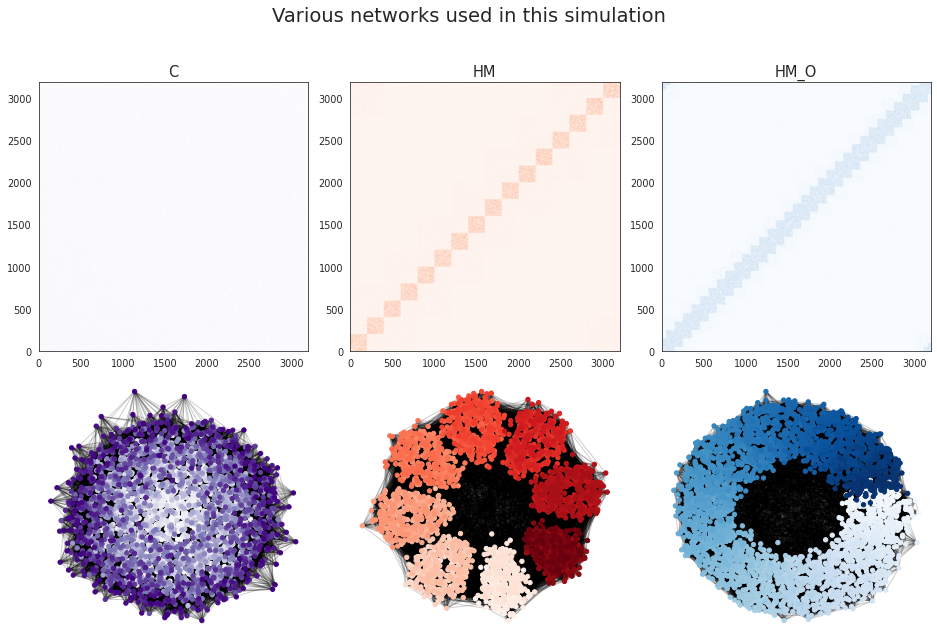

In [5]:
# HIDE CODE


figsize = (13.5, 9)
dpi = 70

sns.set_style('white')
fig = plt.figure(figsize=figsize, dpi=dpi)
gs = GridSpec(nrows=2, ncols=3, height_ratios=[1.3, 1], hspace=0)

for idx, (k, g) in enumerate(graphs.items()):
    ax0 = fig.add_subplot(gs[0, idx])
    ax1 = fig.add_subplot(gs[1, idx])
    
    im = ax0.imshow(adjacencies[k], cmap=cmaps[k], interpolation='antialiased')
    ax0.invert_yaxis()
    ax0.set_title(k, fontsize=15)

    nx.draw_networkx_nodes(g, poses[k], node_color=range(g.order()), node_size=20, cmap=cmaps[k], ax=ax1)
    nx.draw_networkx_edges(g, poses[k], alpha=0.2, ax=ax1)
    ax1.axis('off')

fig.suptitle('Various networks used in this simulation', fontsize=20, y=1.01)
fig.tight_layout(h_pad=0)
plt.show()

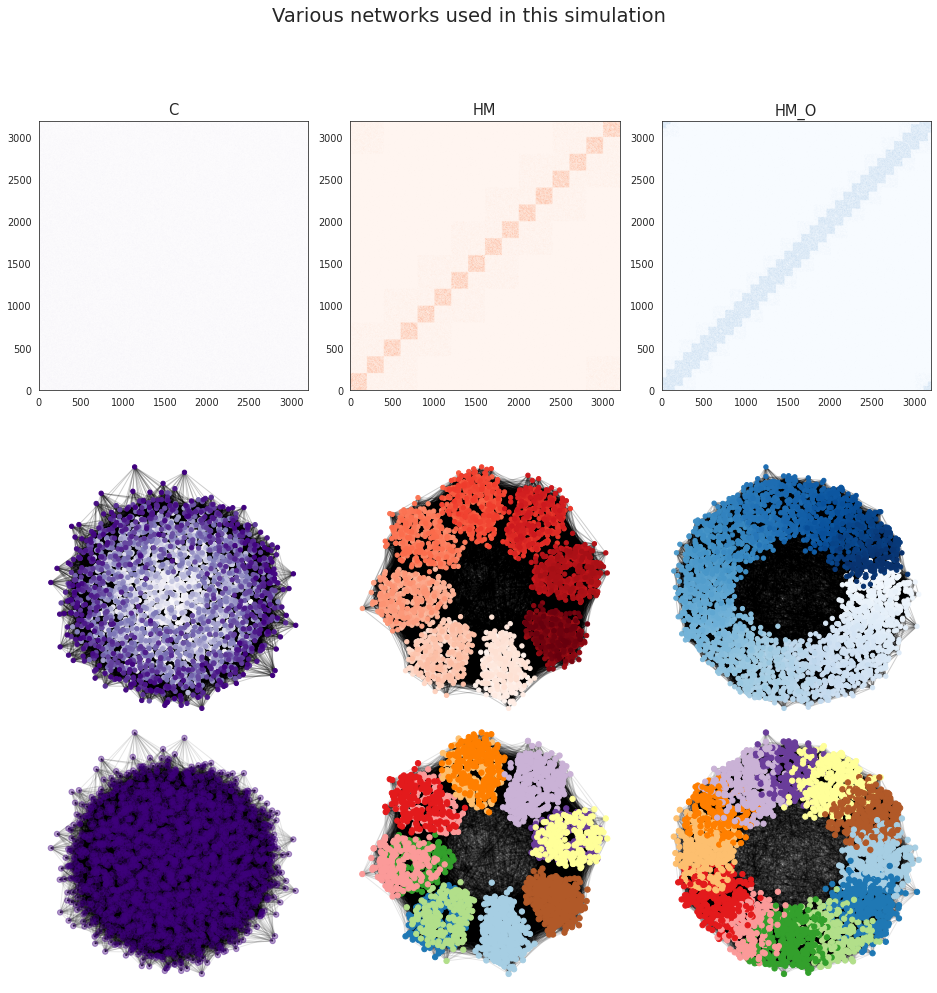

In [6]:
# HIDE CODE


figsize = (13.5, 14)
dpi = 70

sns.set_style('white')
fig = plt.figure(figsize=figsize, dpi=dpi)
gs = GridSpec(nrows=3, ncols=3, height_ratios=[1.5, 1, 1], hspace=0)

for idx, (k, g) in enumerate(graphs.items()):
    ax0 = fig.add_subplot(gs[0, idx])
    ax1 = fig.add_subplot(gs[1, idx])
    ax2 = fig.add_subplot(gs[2, idx])
    
    im = ax0.imshow(adjacencies[k], cmap=cmaps[k], interpolation='antialiased')
    ax0.invert_yaxis()
    ax0.set_title(k, fontsize=15)

    nx.draw_networkx_nodes(g, poses[k], node_color=range(g.order()), node_size=20, cmap=cmaps[k], ax=ax1)
    nx.draw_networkx_edges(g, poses[k], alpha=0.2, ax=ax1)
    ax1.axis('off')
    
    cmap = '_'.join([cmaps[k], 'r']) if k == 'C' else 'Paired'
    alpha = 0.4 if k == 'C' else 1.0
    nx.draw_networkx_nodes(g, poses[k], node_color=list(partitions_true[k].values()),
                           node_size=30, cmap=cmap, alpha=alpha, ax=ax2)
    nx.draw_networkx_edges(g, poses[k], alpha=0.1, ax=ax2)
    ax2.axis('off')

fig.suptitle('Various networks used in this simulation', fontsize=20, y=1.01)
fig.tight_layout(h_pad=0)
plt.show()

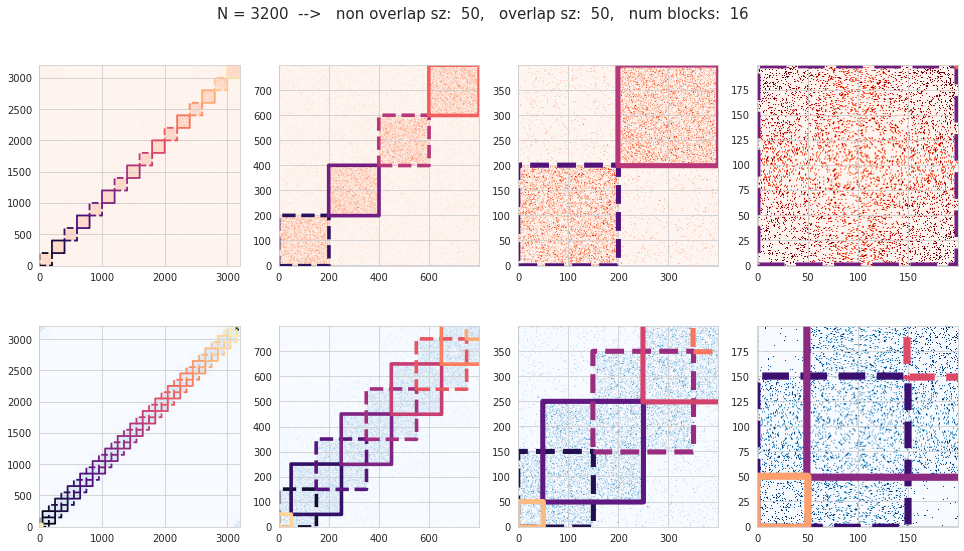

In [7]:
sizes = [num_blocks, 4, 2, 1]
sizes = [(non_overlap + overlap) * 2 * s for s in sizes]

sns.set_style('whitegrid')
fig, axes = plt.subplots(2, len(sizes), figsize=(13.5, 8))

for i, name in enumerate(['HM', 'HM_O']):
    for j, size in enumerate(sizes):
        axes[i, j].imshow(adjacencies[name][:size, :size], cmap=cmaps[name], interpolation="antialiased")
        axes[i, j].invert_yaxis()

        community_list = list(filter(
            lambda x: any(item <= size for item in x),
            communities_true[name].values()
        ))
        _palette = sns.color_palette('magma', n_colors=len(community_list)) # 'Spectral'
        num_incontiguous = 0
        for ll, (comm_list, color) in enumerate(zip(community_list, _palette)):
            contiguous_list = []
            for k, g in itertools.groupby(enumerate(comm_list), lambda ix: ix[0]-ix[1]):
                contiguous_list.append(list(map(itemgetter(1), g)))

            if len(contiguous_list) > 1:
                num_incontiguous += 1

            for item in contiguous_list:
                rect = patches.FancyBboxPatch(
                    (item[0],) * 2,
                    item[-1] - item[0],
                    item[-1] - item[0],
                    linewidth=1.8*np.sqrt(len(adjacencies[name])/size),
                    edgecolor=color,
                    facecolor='none',
                    boxstyle="round,pad=1",
                    ls='--' if ll%2==0 else '-',
                )
                axes[i, j].add_patch(rect)

msg = 'N = {:d}  -->   non overlap sz:  {:d},   overlap sz:  {:d},   num blocks:  {:d}'
msg = msg.format(len(adjacencies['HM']), non_overlap, overlap, num_blocks)
fig.suptitle(msg, fontsize=15)
fig.tight_layout()
plt.show()

## Network measures

### Degree distribution

I chose the parameters in generating the simulation in a way that all these networks have roughly the same digree distribution.

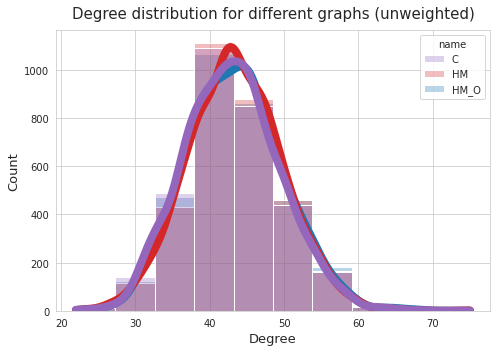

In [8]:
# HIDE CODE


deg_df = pd.DataFrame()

for k, g in graphs.items():
    nodes, degrees = list(zip(*g.degree()))
    data_dict = {
        'name': [k] * len(nodes),
        'node': nodes,
        'deg': degrees,
    }
    deg_df = pd.concat([deg_df, pd.DataFrame.from_dict(data_dict)])
    
sns.set_style('whitegrid')
plt.figure(figsize=(7, 5))
sns.histplot(
    data=deg_df, x='deg', hue='name', palette=colors, kde=True, bins=10,
    element='bars', fill=True, alpha=0.3, line_kws={'lw': 8})
plt.title('Degree distribution for different graphs (unweighted)', fontsize=15, y=1.02)
plt.xlabel('Degree', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.tight_layout()
plt.show()

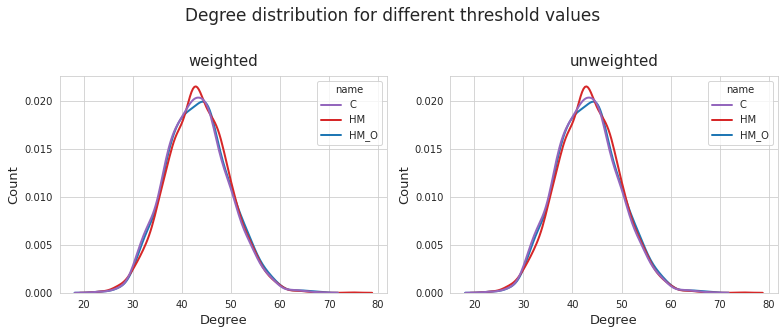

In [9]:
# HIDE CODE


# put results in df
deg_df = pd.DataFrame()

for k, g in graphs.items():
    nodes, degrees = list(zip(*g.degree()))
    nodes, weighted_degrees = list(zip(*g.degree(weight='weight')))
    data_dict = {
        'name': [k] * len(nodes),
        'node': nodes,
        'deg': degrees,
        'deg_w': weighted_degrees,
    }
    deg_df = pd.concat([deg_df, pd.DataFrame.from_dict(data_dict)])
    
    
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
sns.kdeplot(data=deg_df, x='deg_w', hue='name', palette=colors, lw=2, alpha=0.8, ax=axes[0])
sns.kdeplot(data=deg_df, x='deg', hue='name', palette=colors, lw=2, alpha=0.8, ax=axes[1])
axes[0].set_title('weighted', fontsize=15, y=1.02)
axes[1].set_title('unweighted', fontsize=15, y=1.02)

for i in range(2):
    axes[i].set_xlabel('Degree', fontsize=13)
    axes[i].set_ylabel('Count', fontsize=13)

fig.suptitle('Degree distribution for different threshold values', fontsize=17, y=1.02)
fig.tight_layout()
plt.show()

In [ ]:
# HIDE CODE


measures_df = pd.DataFrame()

for k, g in tqdm(graphs.items(), leave=False):
    nodes, degrees = list(zip(*g.degree()))
    
    data_dict = {
        'name': [k] * 8,
        'lbl': [
            'transitivity',
            'avg_clustering',
            'large_clique_size',
            'degree_corr_coef',
            'avg_shortest_path_len',
            'local_efficiency',
            'global_efficiency',
            'sigma',
            # 'omega',
        ],
        'val': [
            transitivity(g),
            average_clustering(g),
            large_clique_size(g),
            degree_pearson_correlation_coefficient(g),
            average_shortest_path_length(g),
            local_efficiency(g),
            global_efficiency(g),
            sigma(g, niter=1, nrand=1, seed=42),
            # omega(g, niter=1, nrand=1, seed=42),
        ],
    }
    measures_df = pd.concat([measures_df, pd.DataFrame.from_dict(data_dict)])

### Other measures

Here I will discuss 8 commonly used network measures and then report their values on different networks in the simulation.

#### i) Clustering related measures
- **transitivity**:
- **avg_clustering**: 
- **large_clique_size**:
- **assortativity**:

#### ii) Path length related measures
- **avg_shortest_path_len**:
- **local_efficiency**:
- **global_efficiency**:

#### iii) Small-world-ness
- **sigma**: introduced in... 


In [ ]:
# HIDE CODE


sns.set_style('whitegrid')
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 5.5))

for idx, lbl in enumerate(measures_df.lbl.unique()):
    i, j = idx//ncols, idx%ncols
    sns.barplot(
        data=measures_df.loc[measures_df.lbl == lbl],
        y='val', x='name', palette=colors, ax=axes[i, j],
    )
    axes[i, j].set_title(lbl, fontsize=12)
    axes[i, j].set_xlabel('')
    if j > 0:
        axes[i, j].set_ylabel('')
    
fig.tight_layout()
plt.show()

interpretation of results:

## Centrality measures

Now we bring our focus from the network as a whole to individual nodes.  Some of these nodes are more *central* than others.  What do I mean by central?  Here is measures I will report on:

- **Degree centrality**:
- **Closeness centrality**:
- **Harmonic centrality**:
- **Betweenness centrality**:
- **Information centrality**:
- **Eigenvector centrality**:
- **Katz centrality**:

Now let's visualize the network based on these centrality measures.

In [ ]:
# HIDE CODE


centralities = {}

for k, g in graphs.items():
    centralities[k] = {
        'degree': nx.degree_centrality(g),
        'closeness': nx.closeness_centrality(g),
        'harmonic': nx.harmonic_centrality(g),
        'betweenness': nx.betweenness_centrality(g),
        'information': nx.information_centrality(g),
        'eigenvector': nx.eigenvector_centrality(g),
        'katz': nx.katz_centrality_numpy(g),
    }

In [ ]:
# HIDE CODE


figsize = (10, 24)
dpi = 70

sns.set_style('white')
nrows, ncols= len(centralities['C']) + 1, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi)

for i, (k, g) in enumerate(graphs.items()):

    nx.draw_networkx_nodes(g, poses[k], node_color=range(g.order()), node_size=20, cmap=cmaps[k], ax=axes[0, i])
    nx.draw_networkx_edges(g, poses[k], alpha=0.4, ax=axes[0, i])
    axes[0, i].set_title(k, fontsize=15)
    if i == 0:
        axes[0, i].set_ylabel('Graph', fontsize=15)
    # axes[0, i].axis('off')
    
    for j, (lbl, vals) in enumerate(centralities[k].items()):
        a = min(vals.values())
        b = max(vals.values())
        normalized_vals = [(x-a) / (b-a) for x in vals.values()]
        
        nx.draw_networkx_nodes(g, poses[k], node_color=normalized_vals,
                               node_size=15, cmap='jet', ax=axes[j+1, i])
        nx.draw_networkx_edges(g, poses[k], alpha=0.2, ax=axes[j+1, i])
        if i == 0:
            axes[j+1, i].set_ylabel(lbl, fontsize=15)
        # axes[j+1, i].axis('off')

fig.tight_layout()

pos0 = axes[0, -1].get_position()
pos1 = axes[-1, -1].get_position()
rect = [
    pos1.x0 + 1.1 * pos1.width, # left
    pos1.y0, # bottom
    pos1.width / 17, # width
    pos0.y0 - pos1.y0 + pos1.height, # height
]
cax = fig.add_axes(rect)
fig.colorbar(cm.ScalarMappable(cmap='jet'), cax=cax, orientation="vertical")
plt.show()

interpret the graph

In [ ]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(13.5, 4))

pairs = [('closeness', 'betweenness'), ('closeness', 'harmonic'), ('closeness', 'degree')]
for idx, (x, y) in enumerate(pairs):
    for k, color in colors.items():
        marker = '^' if k in ['C', 'ER'] else 'o'
        sns.regplot(
            x=list(centralities[k][x].values()),
            y=list(centralities[k][y].values()),
            color=color, ax=axes[idx],
            line_kws={'label': k, 'lw': 2, 'alpha': 0.8},
            scatter_kws={'s': 50, 'marker': marker, 'alpha': 0.1},
        )
    axes[idx].set_xlabel(x, fontsize=13)
    axes[idx].set_ylabel(y, fontsize=13)

axes[0].legend()
fig.suptitle('Scatter plot comparing 2 centrality measures across networks', fontsize=15, y=1.01)
fig.tight_layout()
plt.show()

interpret the graph

## Community structure

Time for fun stuff.  In this section I will study behavior of different community detection algorithms on simulated networks.  First, let's start with a classic, but not so great algorithm.  In this section we will use another network measure known as modularity:

- **Modularity**: $Q = \frac{1}{N}\sum_i$

### Louvain algorithm

Wants to directly maximize Q, modularity

In [ ]:
max_k = 1000
res = np.logspace(-1, 1, max_k+1)

### HM

In [ ]:
results = run_louvain(graphs['HM'], res=res)

In [ ]:
selected_idxs = [180, 400, 650, 750]
plot_louvain_results(results, selected_idxs, partitions_true['HM'])

### HM_O

In [ ]:
results = run_louvain(graphs['HM_O'], res=res)

In [ ]:
selected_idxs = [370, 470, 560, 700]
plot_louvain_results(results, selected_idxs, partitions_true['HM_O'])

## Spectral decomposition

It is interesting to look at eigenspectrum of adjacency matrix.  It can be insightful about linearized dynamics and so on.

In [ ]:
# HIDE CODE


sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(13.5, 9))

num_top_eig = 30
num_bot_eig = 300
for k, color in colors.items():
    ls = '--' if k in ['C', 'ER'] else '-'
    axes[0, 0].plot(sorted(eigs[k][0], reverse=True), lw=2, color=color, ls=ls, label=k)
    axes[0, 1].plot(sorted(eigs[k][0], reverse=True)[:num_top_eig], lw=3, color=color, ls=ls, label=k)
    axes[0, 2].plot(sorted(eigs[k][0], reverse=True)[-num_bot_eig:], lw=3, color=color, ls=ls, label=k)
    
    sns.histplot(eigs[k][0], color=color, label=k, alpha=0.4, ax=axes[1, 0],
                 kde=True, line_kws={'lw': 2, 'ls': ls})
    sns.histplot(eigs[k][0], color=color, label=k, alpha=0.4, ax=axes[1, 1],
                 kde=True, line_kws={'lw': 4, 'ls': ls})
    sns.histplot(eigs[k][0], color=color, label=k, alpha=0.4, ax=axes[1, 2],
                 kde=True, line_kws={'lw': 4, 'ls': ls})
    
axes[0, 0].set_title('all eigenvalues', fontsize=15)
axes[0, 1].set_title('top {:d} eigenvalues'.format(num_top_eig), fontsize=15)
axes[0, 2].set_title('bottom {:d} eigenvalues'.format(num_bot_eig), fontsize=15)
axes[1, 0].set_title('eigenvalue hist', fontsize=15)
axes[1, 1].set_title('zoomed in top values'.format(num_top_eig), fontsize=15)
axes[1, 2].set_title('zoomed in bottom values'.format(num_bot_eig), fontsize=15)

axes[1, 1].set_xlim(5, 30)
axes[1, 2].set_xlim(-11, 0)
for j in range(3):
    axes[0, j].set_xlabel('index', fontsize=12)
    axes[1, j].set_xlabel('eigenvalue', fontsize=12)
    if j == 0:
        axes[0, 0].set_ylabel('eigenvalue', fontsize=12)
        axes[1, 0].set_ylabel('count', fontsize=12)
    else:
        axes[0, 0].set_ylabel('')
        axes[1, 0].set_ylabel('')
    axes[0, j].legend()

fig.suptitle('Eigenvalues are sorted from largest to small for all 4 network types', fontsize=17, y=1.02)
fig.tight_layout()
    
plt.show()

### Localization analysis

Add the anderson stuff here.

#### Inverse participation ratio (IPR)

Blah blah

interpret graph

In [ ]:
# HIDE CODE


num_top = num_blocks
num_bot = num_blocks
plot_items = {
    'Adjacency': adjacencies,
    'Laplacian': laplacians,
    'Hamiltonian': norm_laplacians,
}

sns.set_style('whitegrid')
nrows, ncols = len(plot_items), len(graphs)
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 12), sharex='row', sharey='all')
if len(axes.shape) < 2:
    axes = axes.reshape(nrows, ncols)

for j, k in enumerate(graphs.keys()):
    for i, (name, mat_dict) in enumerate(plot_items.items()):
        w, v = np.linalg.eigh(mat_dict[k])
        ipr = 1 / np.power(v, 4).sum(0)
        ipr /= len(ipr)

        if name == 'Adjacency':
            sorted_indxs = np.argsort(w)
        else:
            sorted_indxs = np.argsort(w)[::-1]

        axes[i, j].scatter(w[sorted_indxs[num_bot:-num_top]], ipr[sorted_indxs[num_bot:-num_top]],
                           color=colors[k], marker='x', s=80, lw=1., alpha=0.3)
        axes[i, j].scatter(w[sorted_indxs[:num_bot]], ipr[sorted_indxs[:num_bot]],
                           color='none', edgecolors=colors[k], marker='^', s=80, lw=2)
        axes[i, j].scatter(w[sorted_indxs[-num_top:]], ipr[sorted_indxs[-num_top:]],
                           color='none', edgecolors=colors[k], s=80, lw=2.5)
        axes[i, j].set_title('{:s}, {:s}'.format(name, k), fontsize=15)
        if i == nrows - 1:
            axes[i, j].set_xlabel('eigenvalue', fontsize=13)
        if j == 0:
            axes[i, j].set_ylabel('IPR', fontsize=13)

msg = 'Eigenvalue / IPR scatter plot, focusing on smallest {:d} and largest {:d} eigenvalues of the Hamiltonian\n'
msg += 'IPR is defined as $(\sum_i \lambda_i^4)^{{-1}}$, where $\lambda_i$ are components of an eigenvector\n'
msg += 'Small IPR values: localized eigenvectors, and larger IPR values: spatially spreadout eigenvectors.'
fig.suptitle(msg.format(num_top, num_bot), fontsize=17, y=1.01)
fig.tight_layout()
plt.show()

interpret graph

#### Plotting eigenvectors

Here I will plot some of the eigenvectors for different networks to see how they are different.

##### top eigenvectors ordered by eigenvalue size

In [ ]:
# HIDE CODE


sns.set_style('whitegrid')
nrows, ncols = 5, 6

for k, (w, v) in eigs.items():
    sort_idxs = np.argsort(w)[::-1]

    fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 7), sharex='all', sharey='all')
    for idx in range(nrows*ncols):
        i, j = idx//ncols, idx%ncols 
            # sort_abs_idxs = np.argsort(np.abs(w))
        axes[i, j].plot(v[:, sort_idxs[idx]], color=colors[k], label=k, lw=1)
        axes[i, j].set_title('#{:d}, eigval = {:.1f}'.format(idx, w[sort_idxs[idx]]))

    fig.suptitle(k, fontsize=20, y=1.)
    fig.tight_layout()
    plt.show()

##### Hamiltonian bottom eigs

In [ ]:
# HIDE CODE


sns.set_style('whitegrid')
nrows, ncols = 5, 6

for k, h in norm_laplacians.items():
    w, v = np.linalg.eigh(h)
    sort_idxs = np.argsort(w)#[::-1]

    fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 7), sharex='all', sharey='all')
    for idx in range(nrows*ncols):
        i, j = idx//ncols, idx%ncols 
            # sort_abs_idxs = np.argsort(np.abs(w))
        axes[i, j].plot(v[:, sort_idxs[idx]], color=colors[k], label=k, lw=1)
        axes[i, j].set_title('#{:d}, eigval = {:.3f}'.format(idx, w[sort_idxs[idx]]))

    fig.suptitle(k, fontsize=20, y=1.)
    fig.tight_layout()
    plt.show()

##### Hamiltonian top eigs

In [ ]:
# HIDE CODE


sns.set_style('whitegrid')
nrows, ncols = 5, 6

for k, h in norm_laplacians.items():
    w, v = np.linalg.eigh(h)
    sort_idxs = np.argsort(w)[::-1]

    fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 7), sharex='all', sharey='all')
    for idx in range(nrows*ncols):
        i, j = idx//ncols, idx%ncols 
            # sort_abs_idxs = np.argsort(np.abs(w))
        axes[i, j].plot(v[:, sort_idxs[idx]], color=colors[k], label=k, lw=1)
        axes[i, j].set_title('#{:d}, eigval = {:.3f}'.format(idx, w[sort_idxs[idx]]))

    fig.suptitle(k, fontsize=20, y=1.)
    fig.tight_layout()
    plt.show()

## Overlapping Communities

### EgoNetSplitter

In [ ]:
from karateclub import EgoNetSplitter

In [ ]:
seeds = [2**i for i in range(10)]

max_k = 100
res = np.logspace(-1, 1, max_k+1)

dict_list = []
for r in tqdm(res):
    for seed in seeds:
        mod = EgoNetSplitter(
            resolution=r,
            seed=seed,
        )
        for name in ['HM', 'HM_O']:
            mod.fit(graphs[name])
            partition = {n: rng.choice(mem) for n, mem in mod.get_memberships().items()}
            ami, nmi, _ = compare_partitions(partitions_true[name], partition)
            data_dict = {
                'res': [r] * 2,
                'seed': [seed] * 2,
                'name': [name] * 2,
                'metric': ['AMI', 'NMI'],
                'value': [ami, nmi],
            }
            dict_list.append(data_dict)

df = pd.DataFrame.from_dict(merge_dicts(dict_list))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i, name in enumerate(['HM', 'HM_O']):
    sns.lineplot(
        data=df.loc[df.name == name],
        x='res',
        y='value',
        hue='metric',
        lw=3,
        palette={'NMI': 'magenta', 'AMI': 'g'},
        ax=axes[i],
    )
    axes[i].set_title(name, fontsize=15)
    axes[i].set_xscale('log')

fig.tight_layout()
plt.show()

### BigClam

In [ ]:
from karateclub import BigClam

In [ ]:
dims = [8, 16, 32, 64, 128]
iters = [30, 50, 70, 90, 130, 190, 300]
learning_rates = [5e-3, 1e-3, 5e-4, 1e-4, 5e-5]
seeds = [2**i for i in range(5)]

dict_list = []


for seed in tqdm(seeds):
    for n_iter in tqdm(iters, leave=False):
        for d in dims:
            for lr in learning_rates:
                for name in ['HM', 'HM_O']:
                    mod = BigClam(
                        dimensions=d,
                        iterations=n_iter,
                        learning_rate=lr,
                        seed=seed,
                    )
                    mod.fit(graphs[name])
                    partition = mod.get_memberships()
                    ami, nmi, _ = compare_partitions(partitions_true[name], partition)
                    data_dict = {
                        'seed': [seed] * 2,
                        'name': [name] * 2,
                        'n_iter': [n_iter] * 2,
                        'dim': [d] * 2,
                        'lr': [lr] * 2,
                        'metric': ['AMI', 'NMI'],
                        'value': [ami, nmi],
                    }
                    dict_list.append(data_dict)

df = pd.DataFrame.from_dict(merge_dicts(dict_list))

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(13.5, 6), sharex='col', sharey='row')

for i, name in enumerate(['HM', 'HM_O']):
    for j, criterion in enumerate(['n_iter', 'dim', 'lr']):
        sns.boxplot(
            data=df.loc[df.name == name],
            x=criterion,
            y='value',
            hue='metric',
            palette={'NMI': 'magenta', 'AMI': 'g'},
            ax=axes[i, j],
        )
        axes[i, j].set_title(name, fontsize=15)
        #axes[i, j].set_xscale('log')

fig.tight_layout()
plt.show()

In [ ]:
selected_df = df.loc[(df.name == 'HM_O') & (df.metric == 'AMI')]
argmax = selected_df.value.argmax()

In [ ]:
selected_df.iloc[argmax]

In [ ]:
mod = BigClam(
    dimensions=selected_df.iloc[argmax].dim,
    iterations=selected_df.iloc[argmax].n_iter,
    learning_rate=selected_df.iloc[argmax].lr,
    seed=42,
)

In [ ]:
mod.fit(graphs['HM_O'])
emb = mod.get_embedding()
partition = mod.get_memberships()

In [ ]:
compare_partitions(partitions_true['HM_O'], partition)

In [ ]:
from sklearn.manifold import TSNE
x = TSNE(n_components=2, perplexity=30.).fit_transform(emb)
x.shape

In [ ]:
plt.scatter(x[:, 0], x[:, 1], c=range(len(x)))

### DeepWalk

In [ ]:
from karateclub import DeepWalk
from sklearn.manifold import TSNE

In [ ]:
model = DeepWalk(dimensions=128, learning_rate=0.01)
model.fit(graphs['HM'])
embedding = model.get_embedding()
x = TSNE(n_components=2, perplexity=50).fit_transform(embedding)
plt.scatter(x[:, 0], x[:, 1], c=range(len(x)), cmap='rocket')

In [ ]:
model.fit(graphs['HM_O'])
embedding = model.get_embedding()
x = TSNE(n_components=2, perplexity=40).fit_transform(embedding)
plt.scatter(x[:, 0], x[:, 1], c=range(len(x)))

### below was not run
### Today: Mar 26
### Come back later and continue

### SVINET

In [117]:
# name = 'HM_O'

# nx.write_adjlist(graphs[name], "{:s}.adjlist".format(name))
# nx.write_weighted_edgelist(graphs[name], "{:s}.weighted.edgelist".format(name))

In [288]:
name = 'HM_O'

save_file = "{:s}.txt".format(name)
nx.write_adjlist(graphs[name], save_file, delimiter='\t')

In [289]:
with open(save_file, "r") as f:
    lines = f.readlines()

In [290]:
with open(save_file, "w") as f:
    for line in lines:
        if '#' not in line:
            f.write(line)

In [ ]:
import os, gct
import numpy as np
import networkx as nx

g = nx.read_weighted_edgelist("HM_O.weighted.edgelist")

ds = gct.from_networkx('HM_O', g, weighted=True, data='weight', description='A hierarchical-modular graph with overlapping community structure')

svinet_cluster = gct.cdc_SVINET(name='SVINET-HM_O', graph=ds, num_cluster=20, inference='link-sampling', seed=42)

np.save('svinet_result.npy', svinet_cluster['clusters'])

### Load results

In [105]:
svinet_comms = np.load('svinet_result.npy', allow_pickle=True).item()

In [106]:
svinet_memships, svinet_partitions = get_partition(svinet_comms, rng)

In [107]:
compare_partitions(true=partitions_true['HM_O'], pred=svinet_partitions)

(0.3436976497421084, 0.4033104624276989, 0.4033104624276989)

In [116]:
[len(x) for x in nx.connected_components(g)]

[800]

In [108]:
svinet_comms

{0: [5,
  518,
  558,
  99,
  615,
  616,
  623,
  630,
  635,
  636,
  637,
  642,
  646,
  647,
  650,
  651,
  653,
  657,
  661,
  662,
  663,
  665,
  666,
  667,
  668,
  669,
  670,
  672,
  673,
  674,
  676,
  677,
  678,
  679,
  681,
  682,
  683,
  684,
  685,
  174,
  686,
  687,
  688,
  689,
  691,
  692,
  693,
  694,
  696,
  697,
  698,
  700,
  701,
  702,
  703,
  704,
  705,
  707,
  708,
  709,
  710,
  712,
  713,
  715,
  716,
  717,
  718,
  719,
  720,
  721,
  722,
  723,
  725,
  726,
  727,
  728,
  217,
  730,
  733,
  734,
  735,
  736,
  737,
  738,
  739,
  740,
  741,
  743,
  746,
  748,
  749,
  751,
  752,
  753,
  754,
  755,
  756,
  757,
  758,
  759,
  760,
  761,
  764,
  765,
  766,
  769,
  773,
  775,
  777,
  779,
  797,
  342],
 1: [521,
  524,
  546,
  561,
  567,
  568,
  576,
  66,
  584,
  585,
  589,
  78,
  593,
  594,
  596,
  597,
  598,
  600,
  603,
  606,
  607,
  609,
  610,
  611,
  613,
  616,
  617,
  619,
  620,
  621,
  62

In [109]:
svinet_memships

{0: [],
 1: [3, 14],
 2: [3, 5, 14],
 3: [3, 11, 14],
 4: [5, 14],
 5: [0, 3, 14],
 6: [3, 5, 12],
 7: [3, 4, 5, 14],
 8: [5, 14],
 9: [3, 14],
 10: [3, 6],
 11: [2, 3, 5, 9, 12, 14],
 12: [5, 14],
 13: [5, 14],
 14: [3, 12, 14],
 15: [3, 14],
 16: [3, 5, 14],
 17: [3, 14, 18],
 18: [5, 14],
 19: [3],
 20: [14, 15],
 21: [12, 13, 14],
 22: [5, 12],
 23: [3, 12],
 24: [3, 5, 12, 14],
 25: [3, 12, 14],
 26: [3, 12, 14],
 27: [],
 28: [3, 6, 13],
 29: [14],
 30: [3, 14, 15],
 31: [3, 12, 14],
 32: [9, 14, 15],
 33: [3, 12, 14, 15],
 34: [3, 6, 12, 14],
 35: [3, 12, 14],
 36: [12, 14],
 37: [3, 5, 6, 9, 12, 14],
 38: [3, 14],
 39: [3, 4, 12, 14],
 40: [3, 14],
 41: [6, 12, 13, 14],
 42: [3, 5, 6, 12, 14],
 43: [5, 12, 14],
 44: [12],
 45: [3, 12],
 46: [6, 12, 13, 14, 15],
 47: [3, 12, 14],
 48: [6, 14],
 49: [3, 6, 12],
 50: [3, 12, 14],
 51: [3, 6, 12, 14],
 52: [6, 15],
 53: [5, 12],
 54: [5, 11, 12, 14],
 55: [12, 14],
 56: [3, 12, 14, 15],
 57: [6, 12, 14, 15],
 58: [3, 12, 14],
 59: 

### Load results (true)

In [298]:
name = 'HM_O'
save_file = "./svinet_results/{:s}.txt".format(name)
nx.write_adjlist(graphs[name], save_file, delimiter='\t')

with open(save_file, "r") as f:
    lines = f.readlines()

with open(save_file, "w") as f:
    for line in lines:
        if '#' not in line:
            f.write(line)

In [343]:
!cd svinet_results/; svinet -file HM_O.txt -n 960 -k 16 -link-sampling -seed 42

+ Output directory: n960-k16-mmsb-seed42-linksampling
+ Writing log to n960-k16-mmsb-seed42-linksampling/infer.log
+ Reading network from HM_O.txt

+ Done reading network
iteration 16: processing 5000 links

In [344]:
!cd svinet_results/; ls

HM_O.txt			   n960-k4-mmsb-seed42-linksampling
n960-k16-mmsb-seed42-linksampling  n960-k8-mmsb-seed42-linksampling
n960-k32-mmsb-seed42-linksampling


In [345]:
# base_dir = '/home/hadi/Documents/workspaces/svinet'
base_dir = './svinet_results'
results_dir = pjoin(base_dir, 'n960-k16-mmsb-seed42-linksampling')
results_dir

'./svinet_results/n960-k16-mmsb-seed42-linksampling'

In [346]:
with open(pjoin(results_dir, 'groups.txt'), "r") as f:
    lines = f.readlines()

membership = {}
for line in lines:
    data = line.strip('\n').split('\t')
    n = int(data[1])
    vec = [float(s) for s in data[2:]]
    membership[n] = vec

membership = dict(sorted(membership.items()))

In [347]:
x = np.concatenate([np.reshape(item, (1, -1)) for item in membership.values()])
x.shape

(960, 16)

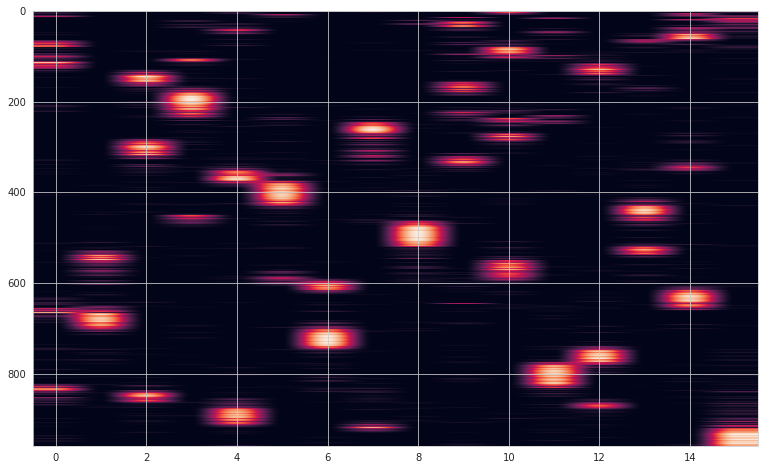

In [348]:
plt.figure(figsize=(13.5, 8))
plt.imshow(x, aspect=0.01)

In [349]:
partition_svinet = np.argmax(x, axis=1)

In [350]:
compare_partitions(true=partitions_true['HM_O'], pred=partition_svinet)

(0.39332702442855094, 0.42112146655664706, 0.42112146655664706)

In [342]:
32

(0.5179863274373203, 0.5616396752918215, 0.5616396752918213)

In [333]:
4

(0.26408423888551574, 0.27252778200208716, 0.27252778200208716)

In [321]:
16

(0.3968314286025778, 0.4244114343202526, 0.4244114343202526)

In [313]:
8

(0.3166344514992905, 0.3325658615761028, 0.3325658615761028)

In [196]:
rng = np.random.RandomState(RANDOM_STATE)

In [326]:
num_nonzero = 1500

gamma = 0.4
threshold = 0.8

# weights = 

x = rng.power(a=gamma, size=10000)
x = np.array(sorted(x))
#x = [threshold / ((1 - threshold) * item + 1) for item in x]
#x = [item for item in x if item > threshold]

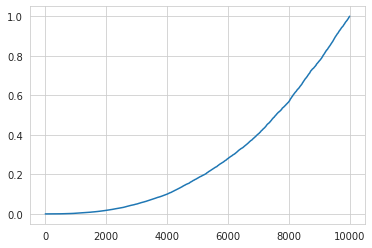

In [327]:
plt.plot(x)

In [300]:
gamma = 1e-3

n = 10000
x = np.linspace(1/n, 1, n)
def power_fn(x, gamma=0.1):
    x_pow = np.power(x, -gamma, dtype=float)
    x_pow -= min(x_pow)
    return x_pow / x_pow.sum()

In [301]:
y = power_fn(x, gamma)

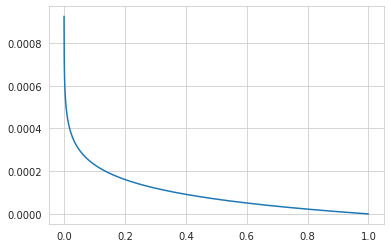

In [302]:
plt.plot(x, y)

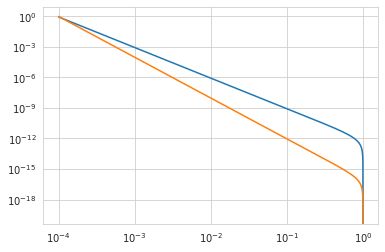

In [310]:
plt.loglog(x, power_fn(x, 3))
plt.loglog(x, power_fn(x, 4))

## Real data

In [3]:
# HIDE CODE

run_duration = 600   # 600 seconds
ca_fs = 10
exclude = 60

ca = load_data(
    load_dir=processed_dir,
    keywords=['ca', 'ses-1', 'sub-SLC06', 'rest'],
    ca_fs=ca_fs,
    run_duration=run_duration,
    exclude=exclude,
    verbose=True,
) 

Data from 4 runs loaded:

['sub-SLC06_ses-1_run-1_task-rest_ca.npy',
 'sub-SLC06_ses-1_run-3_task-rest_ca.npy',
 'sub-SLC06_ses-1_run-5_task-rest_ca.npy',
 'sub-SLC06_ses-1_run-7_task-rest_ca.npy']

-->  60 s  <-- excluded from the beginning of each run. Combined runs duration:

00 - 00:36:00  (dd - hh:mm:ss)



In [4]:
npix_x, npix_y, nt = ca.shape
npix_x, npix_y, nt

(190, 186, 21600)

## Detect anomalies

In [5]:
window = 50
num_stds = 5
num_filter = 5

anomalies = detect_anomalies(
    ca,
    window=window,
    num_stds=num_stds,
    num_filter=num_filter,
)

47 % of all pixels contain at least one anomalous time period


## Bandpass (full data) + Comm

In [6]:
order = 2
lowcut, highcut = 0.001, 4.0

ca_bp = apply_bandpass(
    ca,
    fs=ca_fs,
    lowcut=lowcut,
    highcut=highcut,
    order=order,
)
ca_bp.shape

(190, 186, 21600)

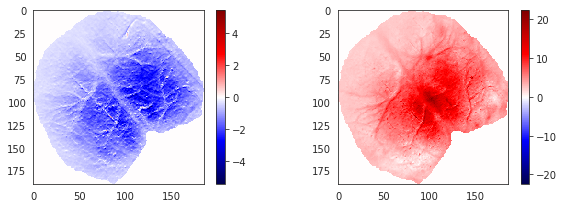

In [7]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
data = ca_bp.mean(-1)
vminmax = np.max(np.abs(data))
plt.imshow(data, cmap='seismic', vmin=-vminmax, vmax=vminmax, interpolation='none')
plt.colorbar()

plt.subplot(122)
data = ca.mean(-1)
vminmax = np.max(np.abs(data))
plt.imshow(data, cmap='seismic', vmin=-vminmax, vmax=vminmax, interpolation='none')
plt.colorbar()

plt.show()

### Downsample

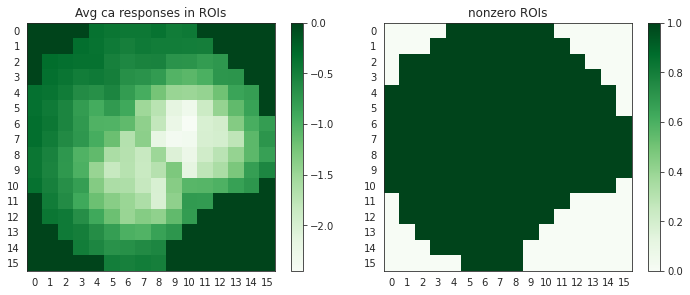

In [8]:
size = 16
downsampled = downsample(ca_bp, size=size)
plot_downsampled(downsampled)

In [9]:
thresholds = [0.7, 0.73, 0.75, 0.78, 0.8, 0.82, 0.85]

df, labels = get_df(downsampled, filter_idxs=anomalies['filter_indxs'])
pearson, pearson_corr, spearman, spearman_corr = get_corrs(df, thresholds=thresholds)

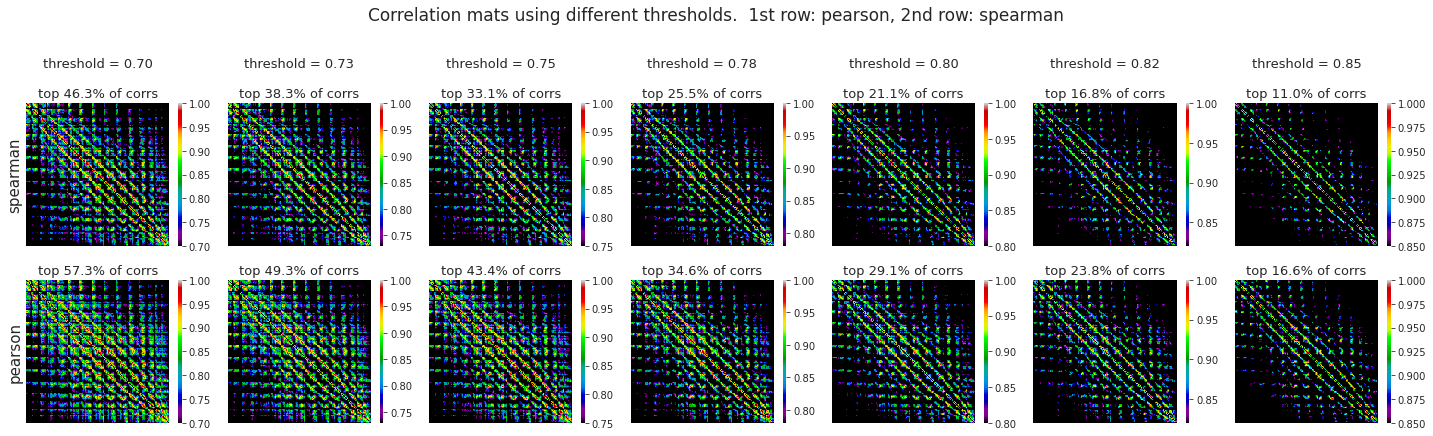

In [10]:
plot_corrs(spearman, pearson, thresholds, figsize=(20, 6))

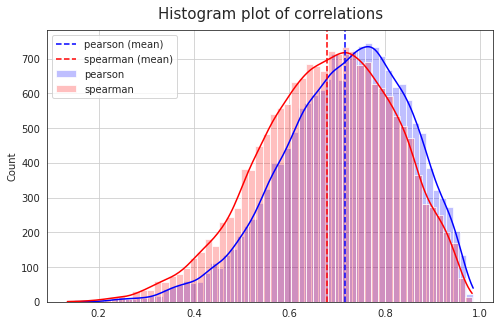

In [11]:
plot_corr_hist(spearman_corr, pearson_corr)

In [12]:
max_k = 1000
res = np.logspace(-1, 1, max_k+1)

g = nx.from_numpy_matrix(spearman[0.82])
communities, modularities, num_communities = run_louvain(g, res=res)

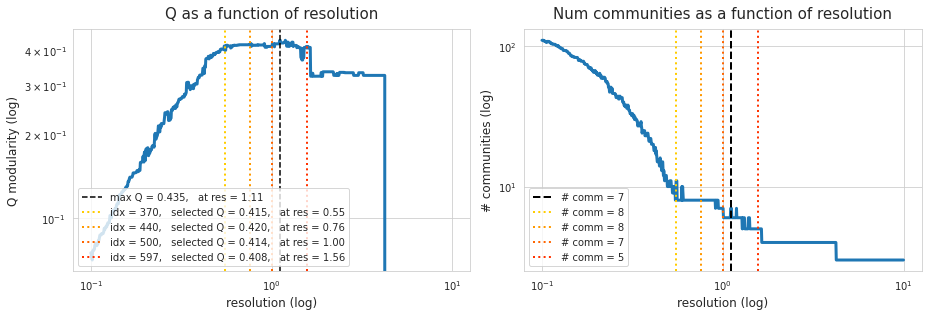

In [13]:
selected_idxs = [370, 440, 500, 597]
plot_louvain_results(modularities, num_communities, selected_idxs)

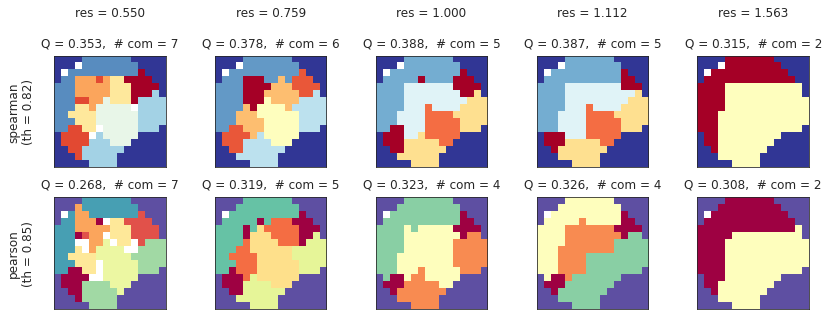

In [14]:
plot_louvain_communities(
    spearman=spearman,
    pearson=pearson,
    modularities=modularities,
    selected_idxs=selected_idxs,
    spearman_th=0.82,
    pearson_th=0.85,
)

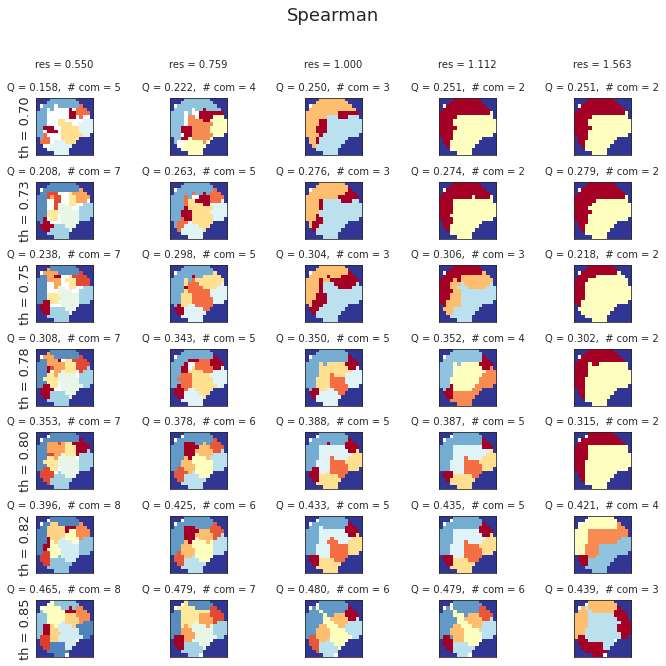

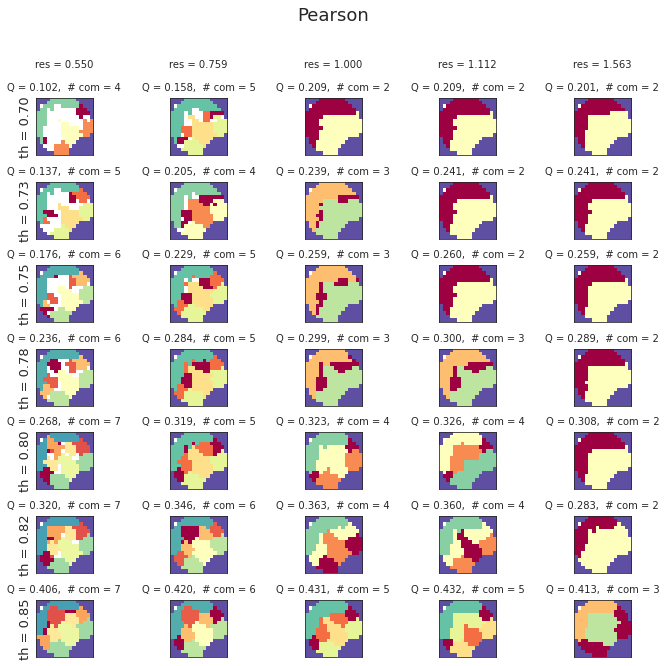

In [15]:
plot_louvain_extended(
    plot_data={'Spearman': spearman, 'Pearson': pearson},
    modularities=modularities,
    selected_idxs=selected_idxs,
)

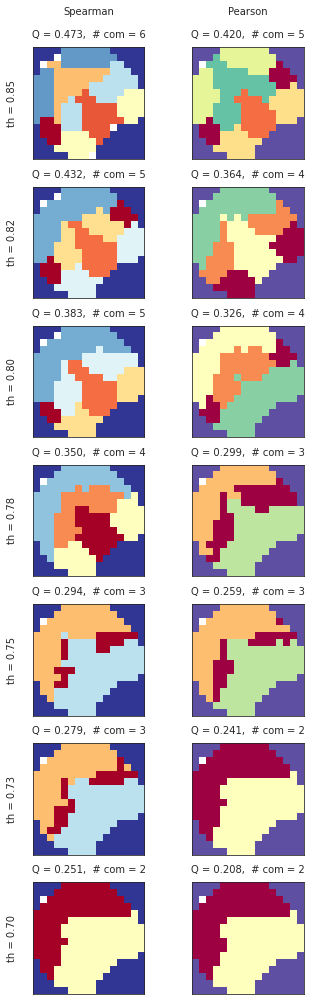

In [16]:
plot_leiden(spearman, pearson)

## Sample to get binary A

### Bernoulli

In [17]:
thresholds = np.linspace(0.7, 0.95, 26)
pearson, pearson_corr, spearman, spearman_corr = get_corrs(df, thresholds=thresholds)

In [18]:
rng = np.random.RandomState(RANDOM_STATE)

a_spearman, a_pearson = {}, {}
for th in spearman.keys():
    a_spearman[th] = rng.binomial(1, spearman[th])
    a_pearson[th] = rng.binomial(1, pearson[th])

#### Weighted

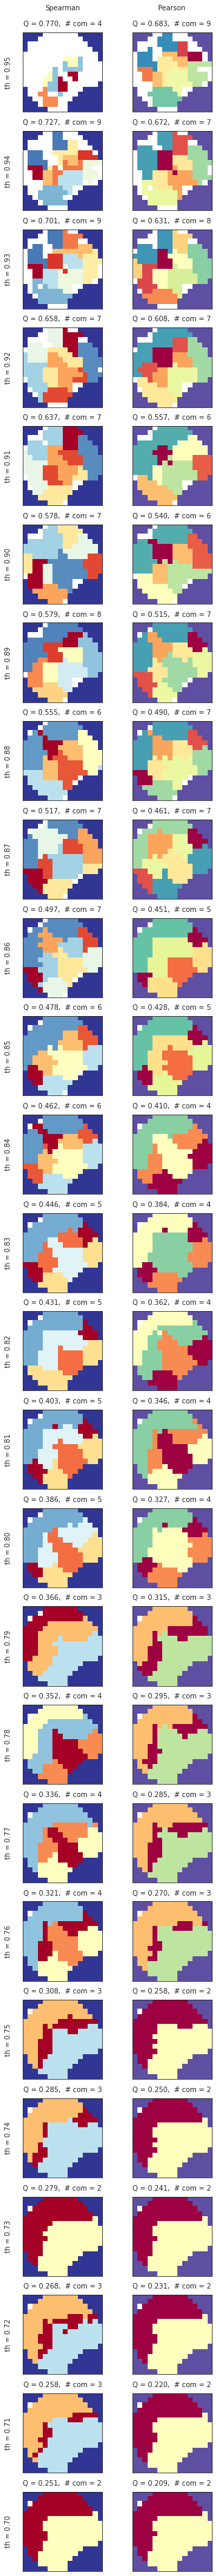

In [19]:
plot_leiden(spearman, pearson)

#### Bernoulli Sampled

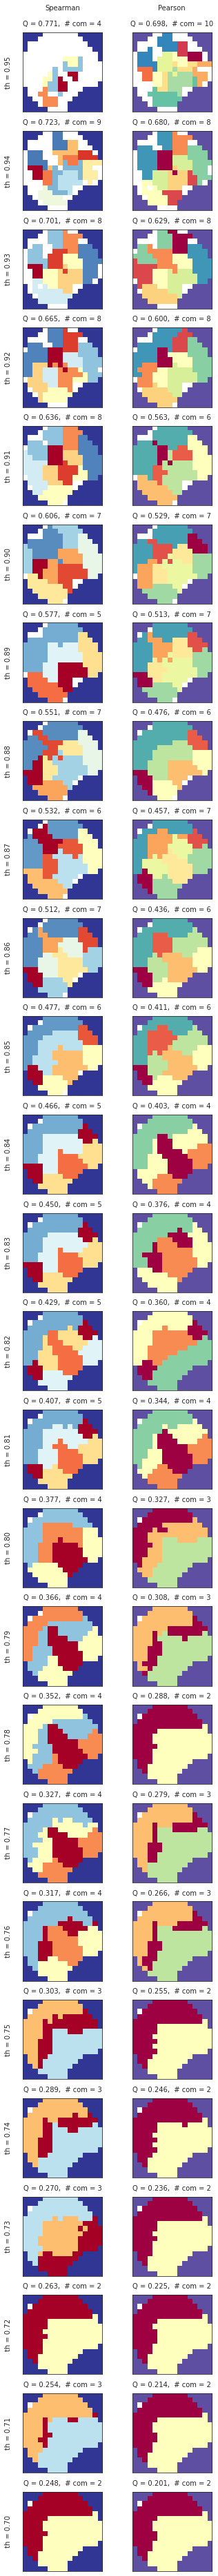

In [20]:
plot_leiden(a_spearman, a_pearson)

### Poisson

In [21]:
thresholds = np.linspace(0.7, 0.90, 21)
pearson, pearson_corr, spearman, spearman_corr = get_corrs(df, thresholds=thresholds)

In [22]:
a_spearman, a_pearson = {}, {}
for th in spearman.keys():
    a_spearman[th] = rng.poisson(spearman[th])
    a_pearson[th] = rng.poisson(pearson[th])

#### Weighted

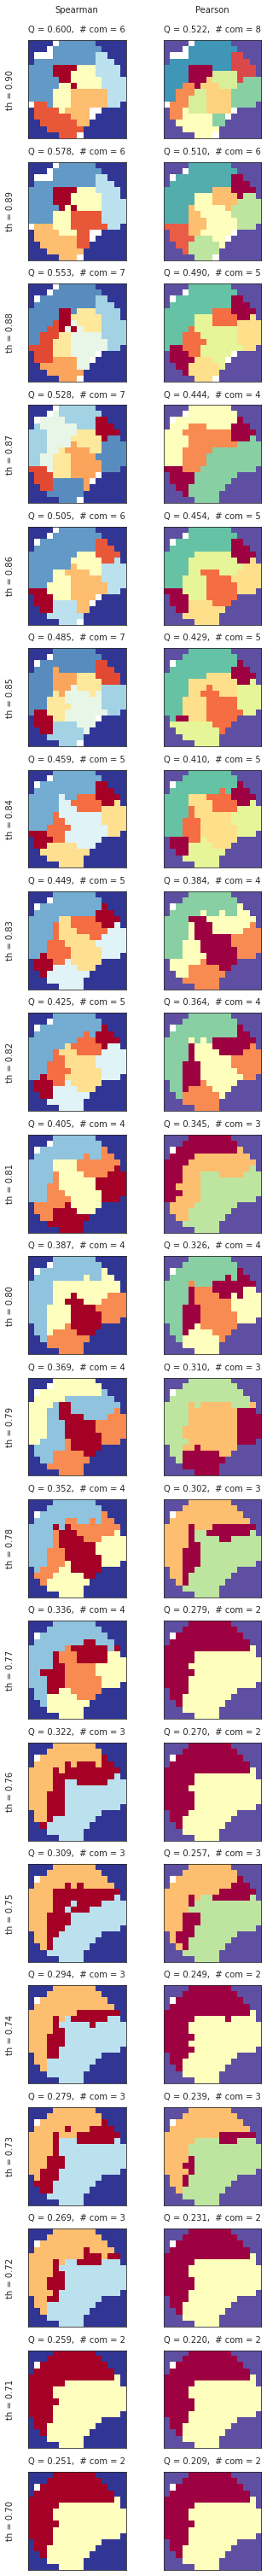

In [23]:
plot_leiden(spearman, pearson)

#### Poisson Sampled

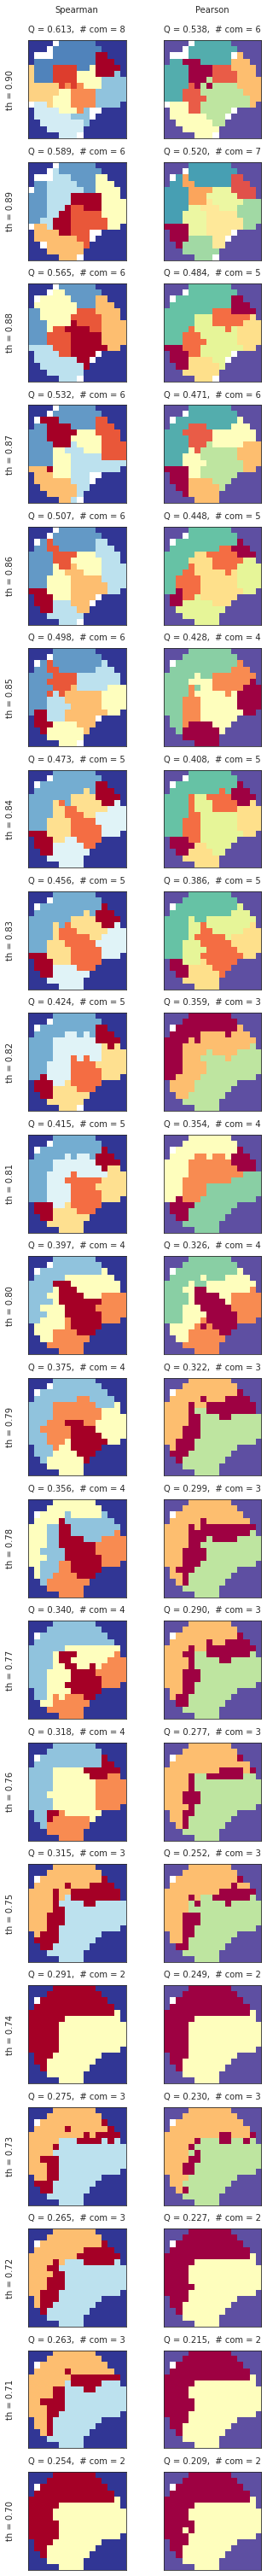

In [24]:
plot_leiden(a_spearman, a_pearson)

## Network measures

In [105]:
# HIDE CODE


# get graphs
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
pearson, pearson_corr, spearman, spearman_corr = get_corrs(df, thresholds=thresholds)

graphs = {k: nx.from_numpy_matrix(v) for k, v in spearman.items()}

# put results in df
deg_df = pd.DataFrame()

for k, g in graphs.items():
    nodes, degrees = list(zip(*g.degree()))
    nodes, weighted_degrees = list(zip(*g.degree(weight='weight')))
    data_dict = {
        'name': [np.round(k, decimals=2)] * len(nodes),
        'node': nodes,
        'deg': degrees,
        'deg_w': weighted_degrees,
    }
    deg_df = pd.concat([deg_df, pd.DataFrame.from_dict(data_dict)])

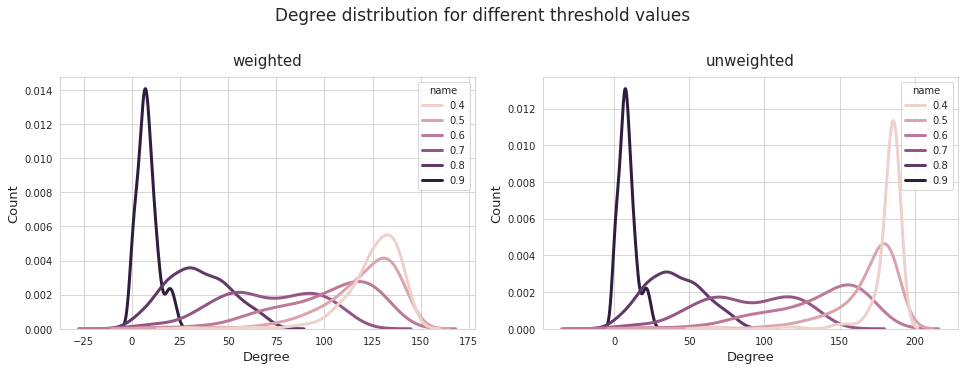

In [106]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(13.5, 5))
sns.kdeplot(data=deg_df, x='deg_w', hue='name', lw=3, alpha=0.8, ax=axes[0])
sns.kdeplot(data=deg_df, x='deg', hue='name', lw=3, alpha=0.8, ax=axes[1])
axes[0].set_title('weighted', fontsize=15, y=1.02)
axes[1].set_title('unweighted', fontsize=15, y=1.02)

for i in range(2):
    axes[i].set_xlabel('Degree', fontsize=13)
    axes[i].set_ylabel('Count', fontsize=13)

fig.suptitle('Degree distribution for different threshold values', fontsize=17, y=1.02)
fig.tight_layout()
plt.show()

### closer look at th = 0.75-0.85

In [107]:
# HIDE CODE


# get graphs
thresholds = np.linspace(0.75, 0.85, 11)
pearson, pearson_corr, spearman, spearman_corr = get_corrs(df, thresholds=thresholds)

graphs = {k: nx.from_numpy_matrix(v) for k, v in spearman.items()}

# put results in df
deg_df = pd.DataFrame()

for k, g in graphs.items():
    nodes, degrees = list(zip(*g.degree()))
    nodes, weighted_degrees = list(zip(*g.degree(weight='weight')))
    data_dict = {
        'name': [np.round(k, decimals=2)] * len(nodes),
        'node': nodes,
        'deg': degrees,
        'deg_w': weighted_degrees,
    }
    deg_df = pd.concat([deg_df, pd.DataFrame.from_dict(data_dict)])

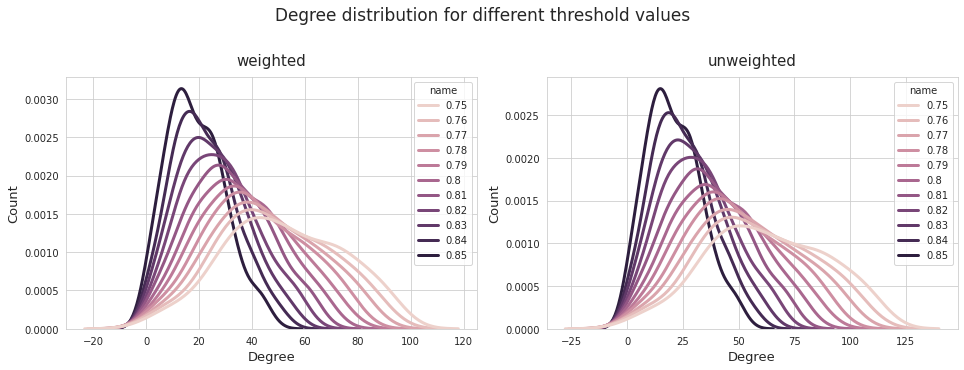

In [108]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(13.5, 5))
sns.kdeplot(data=deg_df, x='deg_w', hue='name', lw=3, alpha=0.8, ax=axes[0])
sns.kdeplot(data=deg_df, x='deg', hue='name', lw=3, alpha=0.8, ax=axes[1])
axes[0].set_title('weighted', fontsize=15, y=1.02)
axes[1].set_title('unweighted', fontsize=15, y=1.02)

for i in range(2):
    axes[i].set_xlabel('Degree', fontsize=13)
    axes[i].set_ylabel('Count', fontsize=13)

fig.suptitle('Degree distribution for different threshold values', fontsize=17, y=1.02)
fig.tight_layout()
plt.show()

### Other network measures

In [112]:
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
pearson, pearson_corr, spearman, spearman_corr = get_corrs(df, thresholds=thresholds)
graphs = {k: nx.from_numpy_matrix(v) for k, v in spearman.items()}

In [113]:
# HIDE CODE


measures_df = pd.DataFrame()

for k, g in tqdm(graphs.items()):
    nodes, degrees = list(zip(*g.degree()))
    
    data_dict = {
        'name': [k] * 6,
        'lbl': [
            'transitivity',
            'avg_clustering',
            'large_clique_size',
            'degree_corr_coef',
            # 'avg_shortest_path_len',
            'local_efficiency',
            'global_efficiency',
            # 'sigma',
            # 'omega',
        ],
        'val': [
            transitivity(g),
            average_clustering(g, weight='weight'),
            large_clique_size(g),
            degree_pearson_correlation_coefficient(g, weight='weight'),
            # average_shortest_path_length(g),
            local_efficiency(g),
            global_efficiency(g),
            # sigma(g, niter=1, nrand=1, seed=42),
            # omega(g, niter=1, nrand=1, seed=42),
        ],
    }
    measures_df = pd.concat([measures_df, pd.DataFrame.from_dict(data_dict)])

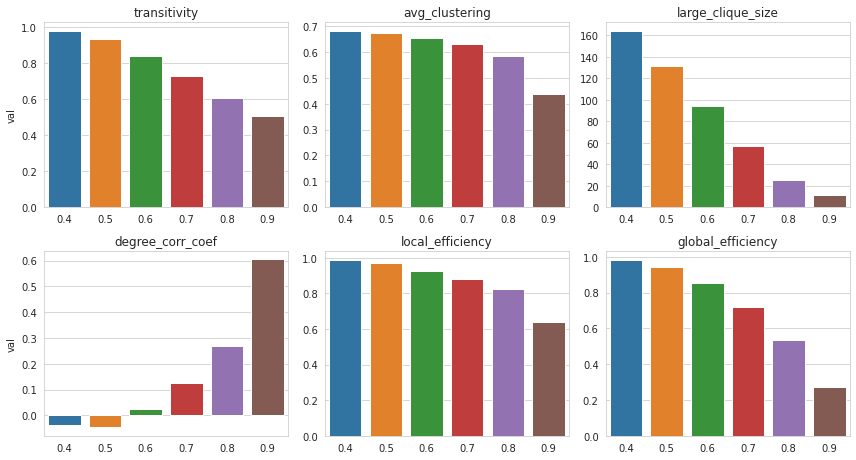

In [117]:
# HIDE CODE


sns.set_style('whitegrid')
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6.5))

for idx, lbl in enumerate(measures_df.lbl.unique()):
    i, j = idx//ncols, idx%ncols
    sns.barplot(
        data=measures_df.loc[measures_df.lbl == lbl],
        y='val', x='name', ax=axes[i, j],
    )
    axes[i, j].set_title(lbl, fontsize=12)
    axes[i, j].set_xlabel('')
    if j > 0:
        axes[i, j].set_ylabel('')
    
fig.tight_layout()
plt.show()

### Eigenvalue analysis

In [143]:
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
pearson, pearson_corr, spearman, spearman_corr = get_corrs(df, thresholds=thresholds)
graphs = {k: nx.from_numpy_matrix(v) for k, v in spearman.items()}

adjacencies = spearman.copy()
laplacians = {k: nx.laplacian_matrix(g).toarray() for k, g in graphs.items()}
norm_laplacians = {k: nx.normalized_laplacian_matrix(g).toarray() for k, g in graphs.items()}
pallette = sns.color_palette('tab10', n_colors=len(graphs))
colors = {k: list(pallette)[i] for i, k in enumerate(graphs.keys())}

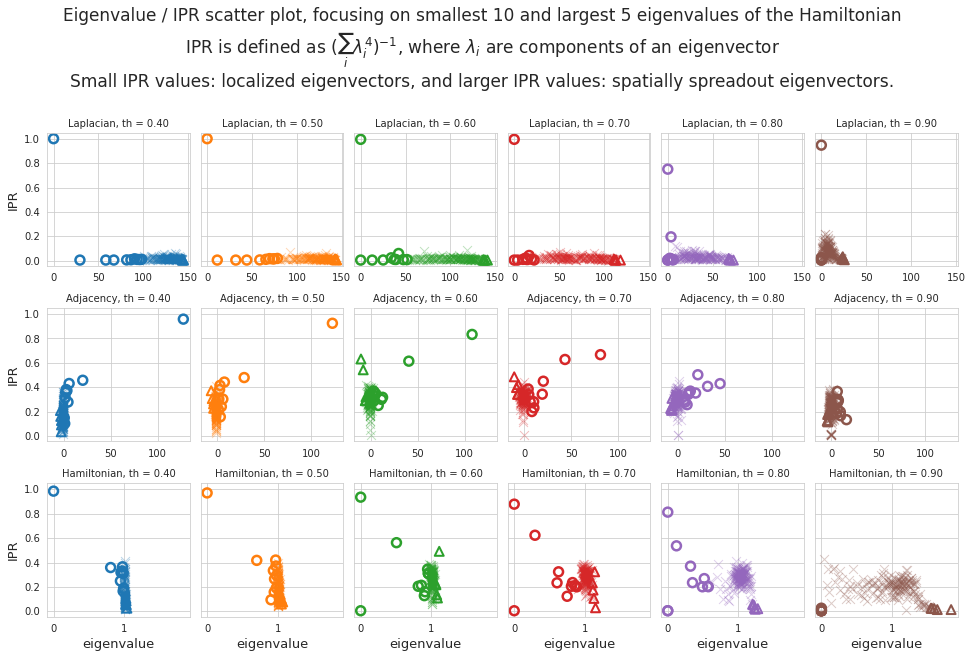

In [144]:
# HIDE CODE


num_top = 10
num_bot = 5
plot_items = {
    'Laplacian': laplacians,
    'Adjacency': adjacencies,
    'Hamiltonian': norm_laplacians,
}

sns.set_style('whitegrid')
nrows, ncols = len(plot_items), len(graphs)
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 9), sharex='row', sharey='all')
if len(axes.shape) < 2:
    axes = axes.reshape(nrows, ncols)

for j, k in enumerate(graphs.keys()):
    for i, (name, mat_dict) in enumerate(plot_items.items()):
        w, v = np.linalg.eigh(mat_dict[k])
        ipr = 1 / np.power(v, 4).sum(0)
        ipr /= len(ipr)

        if name == 'Adjacency':
            sorted_indxs = np.argsort(w)
        else:
            sorted_indxs = np.argsort(w)[::-1]

        axes[i, j].scatter(w[sorted_indxs[num_bot:-num_top]], ipr[sorted_indxs[num_bot:-num_top]],
                           color=colors[k], marker='x', s=80, lw=1., alpha=0.3)
        axes[i, j].scatter(w[sorted_indxs[:num_bot]], ipr[sorted_indxs[:num_bot]],
                           color='none', edgecolors=colors[k], marker='^', s=80, lw=2)
        axes[i, j].scatter(w[sorted_indxs[-num_top:]], ipr[sorted_indxs[-num_top:]],
                           color='none', edgecolors=colors[k], s=80, lw=2.5)
        axes[i, j].set_title('{:s}, th = {:.2f}'.format(name, k), fontsize=10)
        if i == nrows - 1:
            axes[i, j].set_xlabel('eigenvalue', fontsize=13)
        if j == 0:
            axes[i, j].set_ylabel('IPR', fontsize=13)

msg = 'Eigenvalue / IPR scatter plot, focusing on smallest {:d} and largest {:d} eigenvalues of the Hamiltonian\n'
msg += 'IPR is defined as $(\sum_i \lambda_i^4)^{{-1}}$, where $\lambda_i$ are components of an eigenvector\n'
msg += 'Small IPR values: localized eigenvectors, and larger IPR values: spatially spreadout eigenvectors.'
fig.suptitle(msg.format(num_top, num_bot), fontsize=17, y=1.01)
fig.tight_layout()
plt.show()

#### Closer look at 0.75-0.85 range

In [145]:
thresholds = np.linspace(0.75, 0.85, 5)
pearson, pearson_corr, spearman, spearman_corr = get_corrs(df, thresholds=thresholds)
graphs = {k: nx.from_numpy_matrix(v) for k, v in spearman.items()}

adjacencies = spearman.copy()
laplacians = {k: nx.laplacian_matrix(g).toarray() for k, g in graphs.items()}
norm_laplacians = {k: nx.normalized_laplacian_matrix(g).toarray() for k, g in graphs.items()}
pallette = sns.color_palette('tab10', n_colors=len(graphs))
colors = {k: list(pallette)[i] for i, k in enumerate(graphs.keys())}

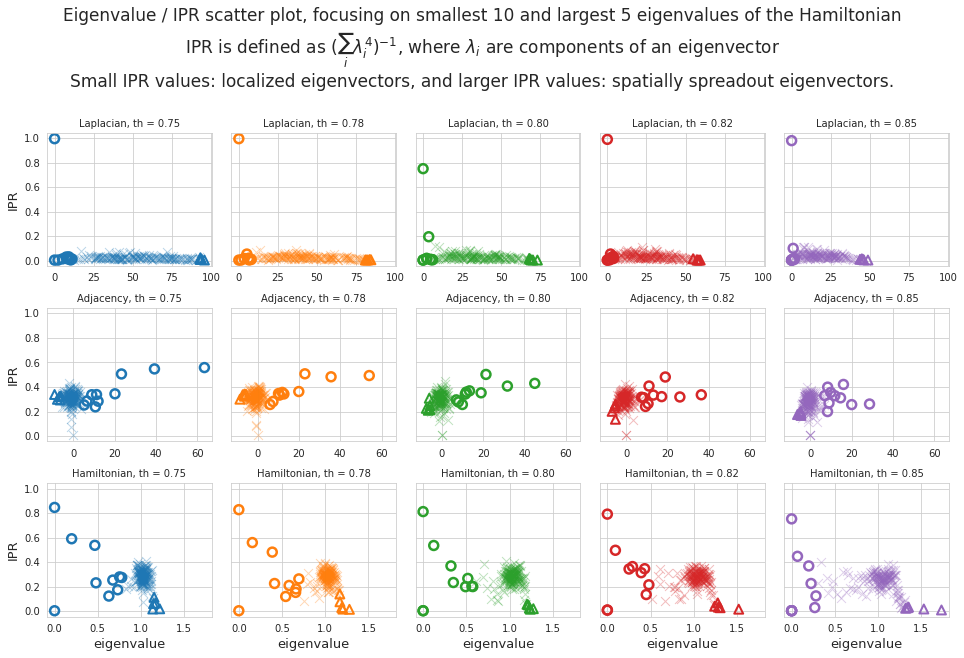

In [146]:
# HIDE CODE


num_top = 10
num_bot = 5
plot_items = {
    'Laplacian': laplacians,
    'Adjacency': adjacencies,
    'Hamiltonian': norm_laplacians,
}

sns.set_style('whitegrid')
nrows, ncols = len(plot_items), len(graphs)
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 9), sharex='row', sharey='all')
if len(axes.shape) < 2:
    axes = axes.reshape(nrows, ncols)

for j, k in enumerate(graphs.keys()):
    for i, (name, mat_dict) in enumerate(plot_items.items()):
        w, v = np.linalg.eigh(mat_dict[k])
        ipr = 1 / np.power(v, 4).sum(0)
        ipr /= len(ipr)

        if name == 'Adjacency':
            sorted_indxs = np.argsort(w)
        else:
            sorted_indxs = np.argsort(w)[::-1]

        axes[i, j].scatter(w[sorted_indxs[num_bot:-num_top]], ipr[sorted_indxs[num_bot:-num_top]],
                           color=colors[k], marker='x', s=80, lw=1., alpha=0.3)
        axes[i, j].scatter(w[sorted_indxs[:num_bot]], ipr[sorted_indxs[:num_bot]],
                           color='none', edgecolors=colors[k], marker='^', s=80, lw=2)
        axes[i, j].scatter(w[sorted_indxs[-num_top:]], ipr[sorted_indxs[-num_top:]],
                           color='none', edgecolors=colors[k], s=80, lw=2.5)
        axes[i, j].set_title('{:s}, th = {:.2f}'.format(name, k), fontsize=10)
        if i == nrows - 1:
            axes[i, j].set_xlabel('eigenvalue', fontsize=13)
        if j == 0:
            axes[i, j].set_ylabel('IPR', fontsize=13)

msg = 'Eigenvalue / IPR scatter plot, focusing on smallest {:d} and largest {:d} eigenvalues of the Hamiltonian\n'
msg += 'IPR is defined as $(\sum_i \lambda_i^4)^{{-1}}$, where $\lambda_i$ are components of an eigenvector\n'
msg += 'Small IPR values: localized eigenvectors, and larger IPR values: spatially spreadout eigenvectors.'
fig.suptitle(msg.format(num_top, num_bot), fontsize=17, y=1.01)
fig.tight_layout()
plt.show()

### Plot Hamiltonian eigvecs

##### Hamiltonian top eigs

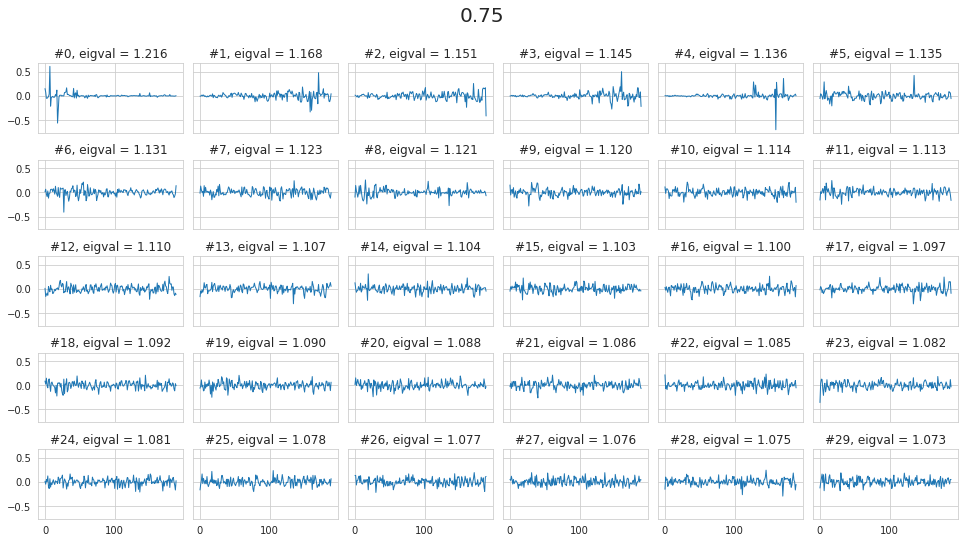

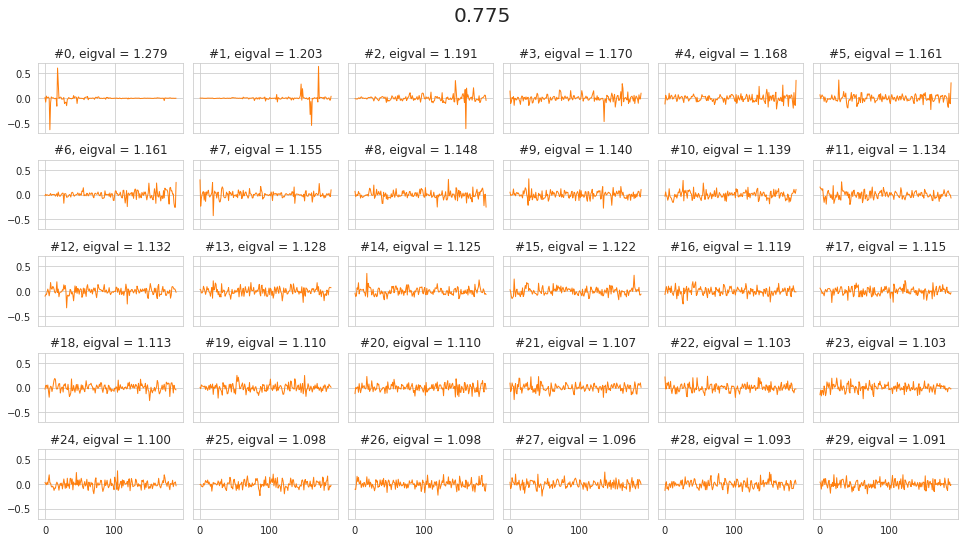

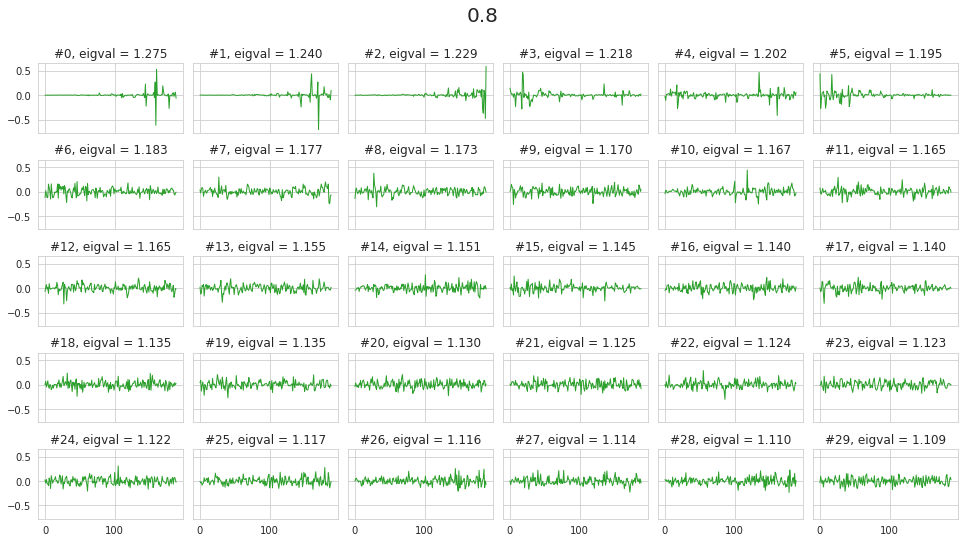

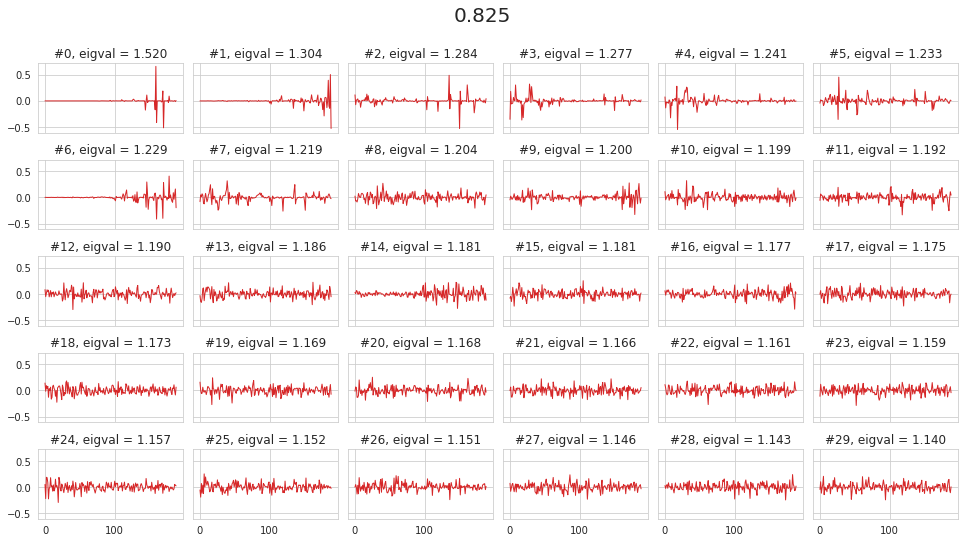

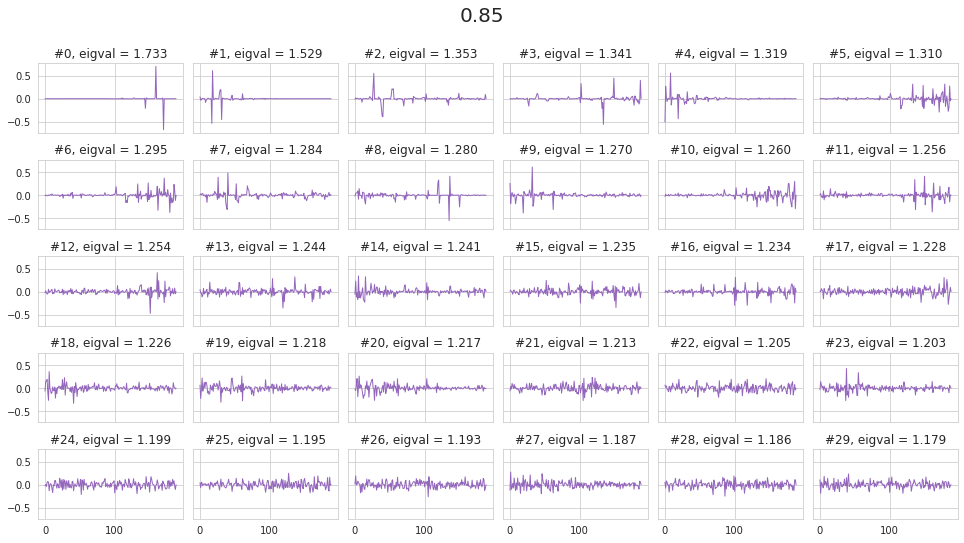

In [150]:
# HIDE CODE


sns.set_style('whitegrid')
nrows, ncols = 5, 6

for k, h in norm_laplacians.items():
    w, v = np.linalg.eigh(h)
    sort_idxs = np.argsort(w)[::-1]

    fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, nrows * 1.5), sharex='all', sharey='all')
    for idx in range(nrows*ncols):
        i, j = idx//ncols, idx%ncols 
            # sort_abs_idxs = np.argsort(np.abs(w))
        axes[i, j].plot(v[:, sort_idxs[idx]], color=colors[k], label=k, lw=1)
        axes[i, j].set_title('#{:d}, eigval = {:.3f}'.format(idx, w[sort_idxs[idx]]))

    fig.suptitle(k, fontsize=20, y=1.)
    fig.tight_layout()
    plt.show()

##### Hamiltonian bottom eigs

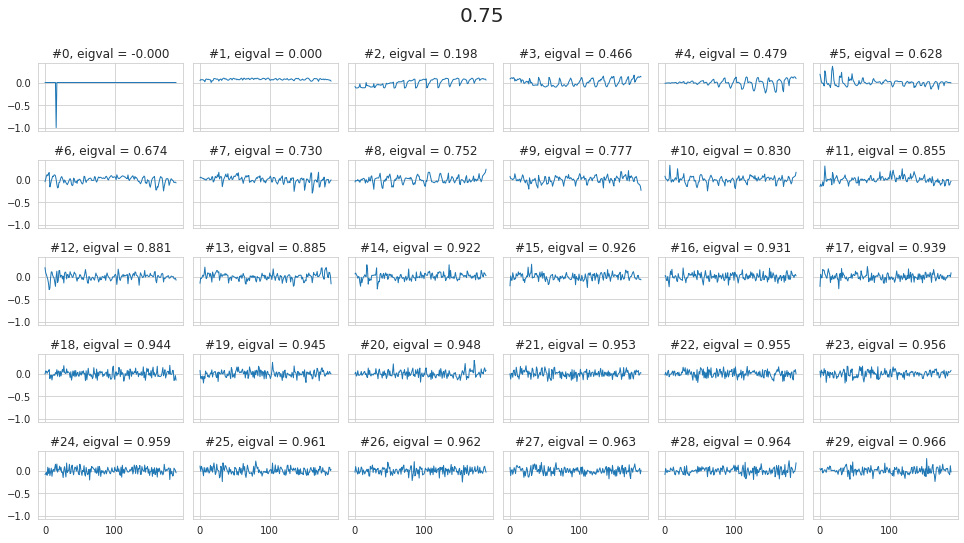

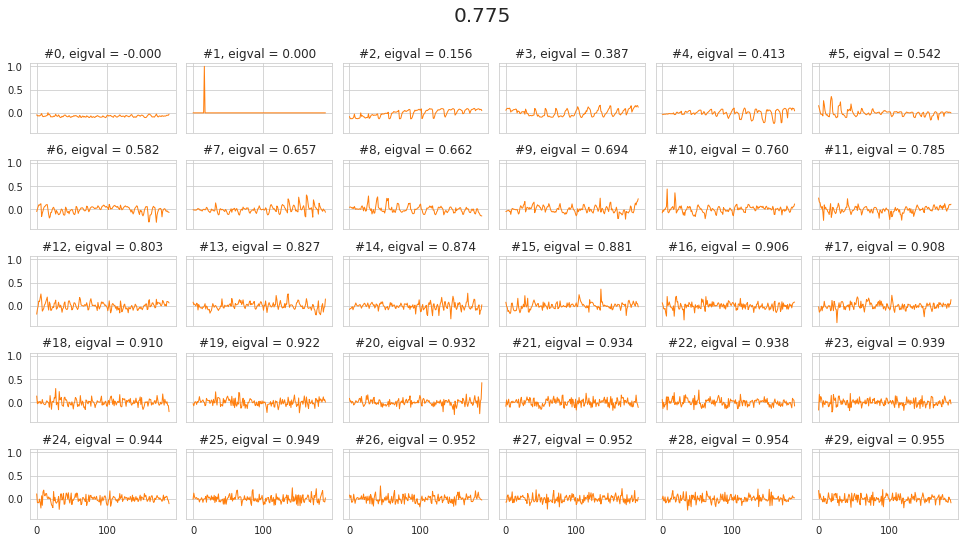

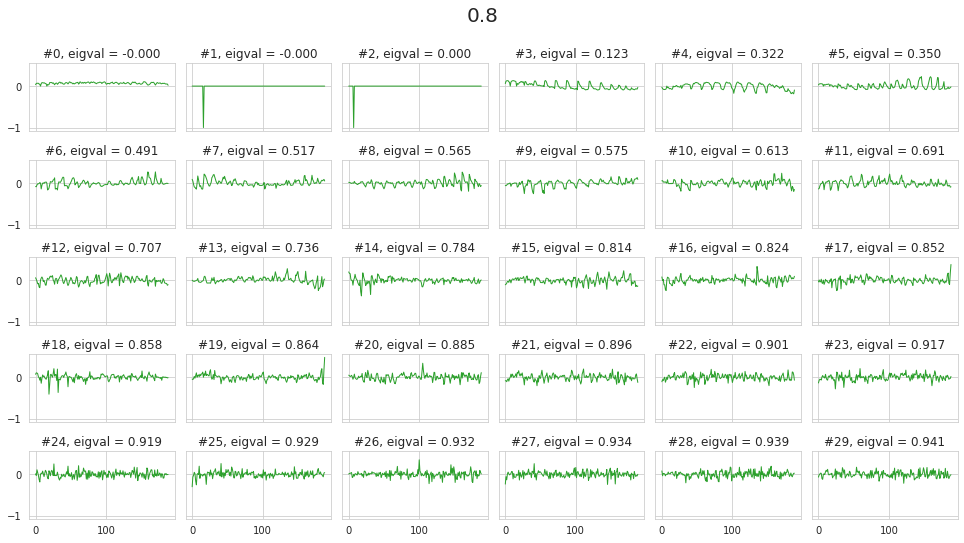

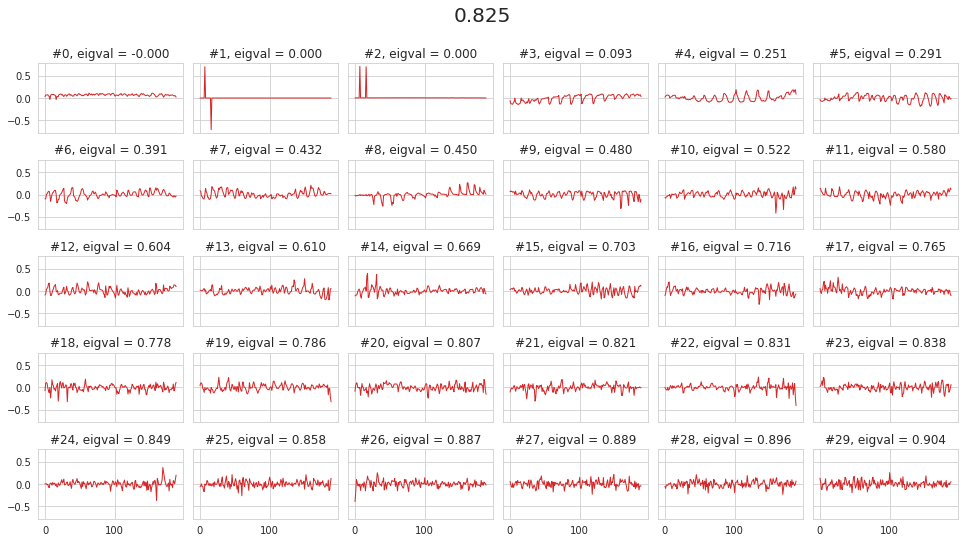

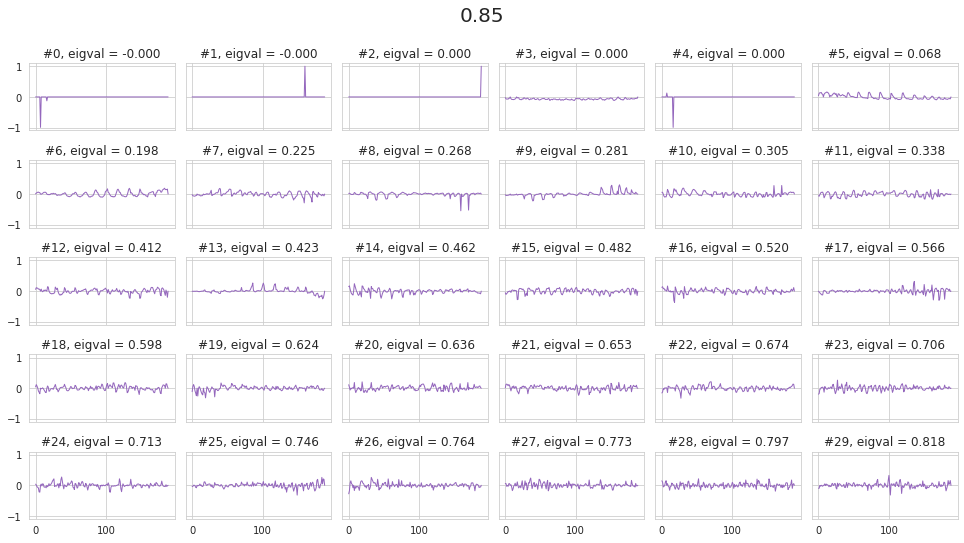

In [151]:
# HIDE CODE


sns.set_style('whitegrid')
nrows, ncols = 5, 6

for k, h in norm_laplacians.items():
    w, v = np.linalg.eigh(h)
    sort_idxs = np.argsort(w)#[::-1]

    fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 1.5 * nrows), sharex='all', sharey='all')
    for idx in range(nrows*ncols):
        i, j = idx//ncols, idx%ncols 
            # sort_abs_idxs = np.argsort(np.abs(w))
        axes[i, j].plot(v[:, sort_idxs[idx]], color=colors[k], label=k, lw=1)
        axes[i, j].set_title('#{:d}, eigval = {:.3f}'.format(idx, w[sort_idxs[idx]]))

    fig.suptitle(k, fontsize=20, y=1.)
    fig.tight_layout()
    plt.show()